# Rossmann Sales Prediction

## Data Fields

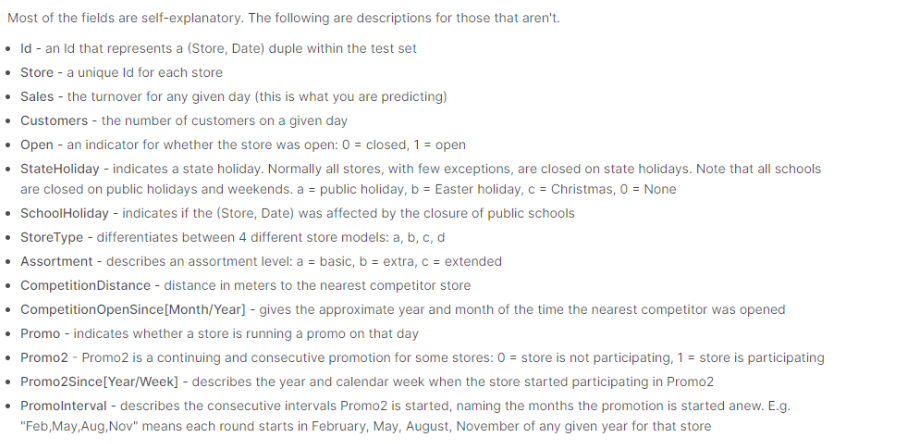

# 0.0 Collecting Data

## 0.0 Imports

In [1]:
import matplotlib.gridspec as gridspec
import numpy               as np
import pandas              as pd
import seaborn             as sns
import xgboost             as xgb
import inflection
import math
import pickle
import warnings
import random

#Visual libraries 
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image
from tabulate              import tabulate
from scipy                 import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import Lasso
from sklearn.linear_model  import LinearRegression
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## 0.1 Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose = False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range( 1,kfold+1 ) ):
        if verbose:
            print(f'\nKFold Number: {k}')
        #Start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7 )

        #Filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date)&(x_training['date'] <= validation_end_date)]

        #Training and validation dataset
        #training
        xtraining = training.drop(['date','sales'], axis = 1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date','sales'], axis = 1)
        yvalidation = validation['sales']

        #model
        m = model.fit( xtraining, ytraining )

        #prediction
        yhat = m.predict( xvalidation )

        #performance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat) )

        #store performance of each iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name':model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype(str), 
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype(str) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype(str),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype(str) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype(str) }, index = [0] )


def ml_error ( model_name, y, yhat ):
    mae  = mean_absolute_error ( y, yhat )  
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error ( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE':mae,
                           'MAPE':mape,
                           'RMSE':rmse}, index=[0] )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    warnings.filterwarnings('ignore')
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    display( HTML('<style>.container{ width: 100% !important; }</style>'))
    pd.set_option( 'display.expand_frame_repr', False)
    sns.set()

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1,rcorr-1)))

def mean_percentage_error(y, yhat):
    return np.mean( (y - yhat) / y )


jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\Gustavo\anaconda3\envs\ds_producao\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Load Dataset

In [3]:
df_sales_raw = pd.read_csv('dataset/train.csv', low_memory=False)
df_store_raw = pd.read_csv('dataset/store.csv', low_memory=False)


# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# 1.0 Data Description

In [4]:
#Creating a copy of the last one section.

df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
#To use standard columns, we gonna rename all columns to snakecase. 
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snake_case = lambda x: inflection.underscore (x)

cols_new = list(map(snake_case, cols_old))

#rename
df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimension

In [8]:
#Checking the dimension of our dataset.
print(f"Number of rows: {df1.shape[0]}")
print(f"Number of columns: {df1.shape[1]}")

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
#We have a wrong type here, so we will transform the column 'date' into 'datetime'.
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [11]:
#Checking for missing values
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [12]:
#There ir three ways to treat missing values:
## I - Delete the lines that exist na;
## II - Using column behavior - mean, median...;
## III - Knowing about the business. Finding why that line is empty seeking out recovering the data.

In [13]:
#Competition Distance:
## If the column is empty, it means that we don't have any competitor close. If we use a big distance (mutch more then the 
## max value) it will means that we don't have anyone closest.

df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month: Month the closiest competitor was opened.
## I - The store doesn't has a closest competitor.
## II - We don't know when the competitor was opened (it could be happened before or after our store begin)
### How the date matters for some machine learning model, we will use them, and it's wrong we say that some store was never opened if we have a competitor.
### If competition_open_since_month is empty, then we will copy the date for here, if isn't, we will use the date that we have. 
### How we are doing the first CRISP cicle, we will follow by this way. This is something that we can change in the future, for our next steps.

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year: year the closiest competitor was opened.
# We gonna use the same thought as before.

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week: Describe the week that promo started.
# If the value was na, the store don't participated of promo;

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year: Describe the year that promo started.
# We gonna use the same thought as before.

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#Promo interval
## We gonna split the column to create a list. If the values was inside the list, we will create a new column called promo2_ativa;

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [14]:
#Check if remain some missing value.
df1.isnull().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistics

It's important to discover metrics about the business. Throught it we can create insights and found mistakes in the dataset.

We gonna use the central tendency and dispersion tendency.

- Central Tendency: Data summary in a single value, like mean or median. When we use the central tendency we need know how it is the dispersion to discover how far it's of this central metric.

- Skew: It describe how it's the deformantion against the normal curve. More to the left side means a positive deformation. More to the right means a negative deformation.

- Kurtosis: It describe de concentration of the values. If has a lot of values concentrated the value will be high. If has few values the value will be low or negative.

In [16]:
num_attributes = df1.select_dtypes( include = ['int64','float64'])
cat_attributes = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [17]:
#Central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std) ).T
d2 = pd.DataFrame( num_attributes.apply(min) ).T
d3 = pd.DataFrame( num_attributes.apply(max) ).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min()) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis() ) ).T


# Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


- Sales: We have a mean and a median close each one of other. It means that we have almost a normal curve on it. Our skew close to one describe that our data is more close to the left side. With the kurtosis being positive, it means that we have a lot of values close to an only point.

- Competition Distance: We have a big diference between the mean and median, it means that we don't have a normal curve and have a lot of outliers. The value of skew it's very high, this means that our data its really close to the begin and the very value of kurtosis means that we have a lot of values concentrated. 

#### 1.7.1.1 Graphs

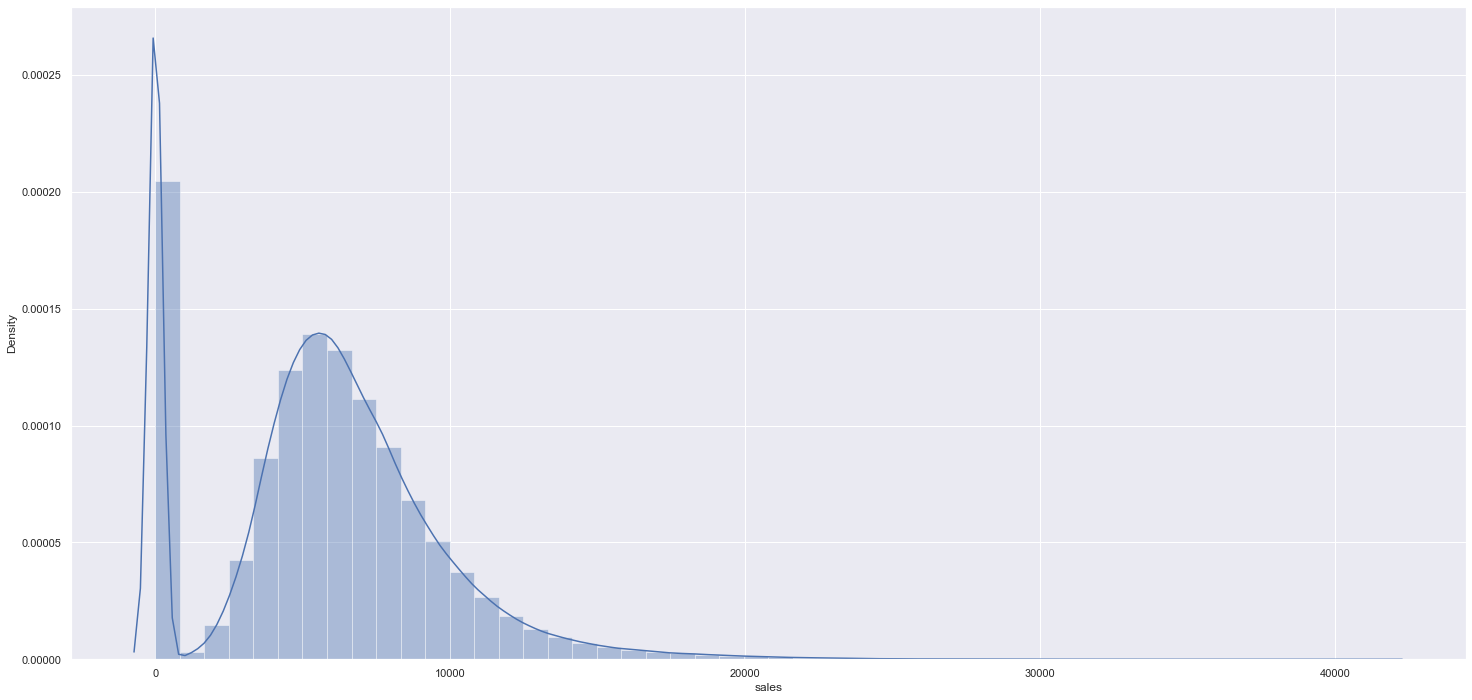

In [18]:
sns.distplot( df1['sales']);

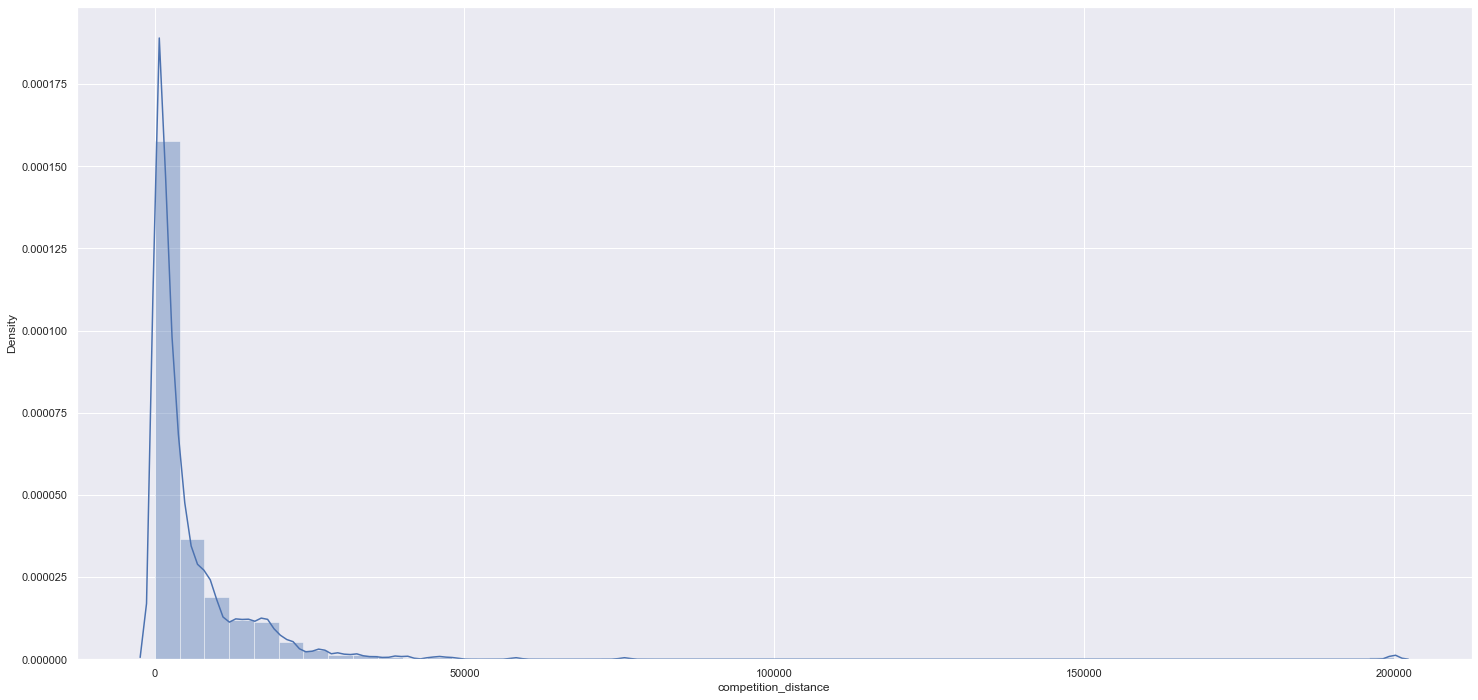

In [19]:
sns.distplot( df1['competition_distance']);

### 1.7.2 Categorical Attributes

We will use this metrics on boxplot to plot the categorical data.

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

#### 1.7.2.1 Graphs

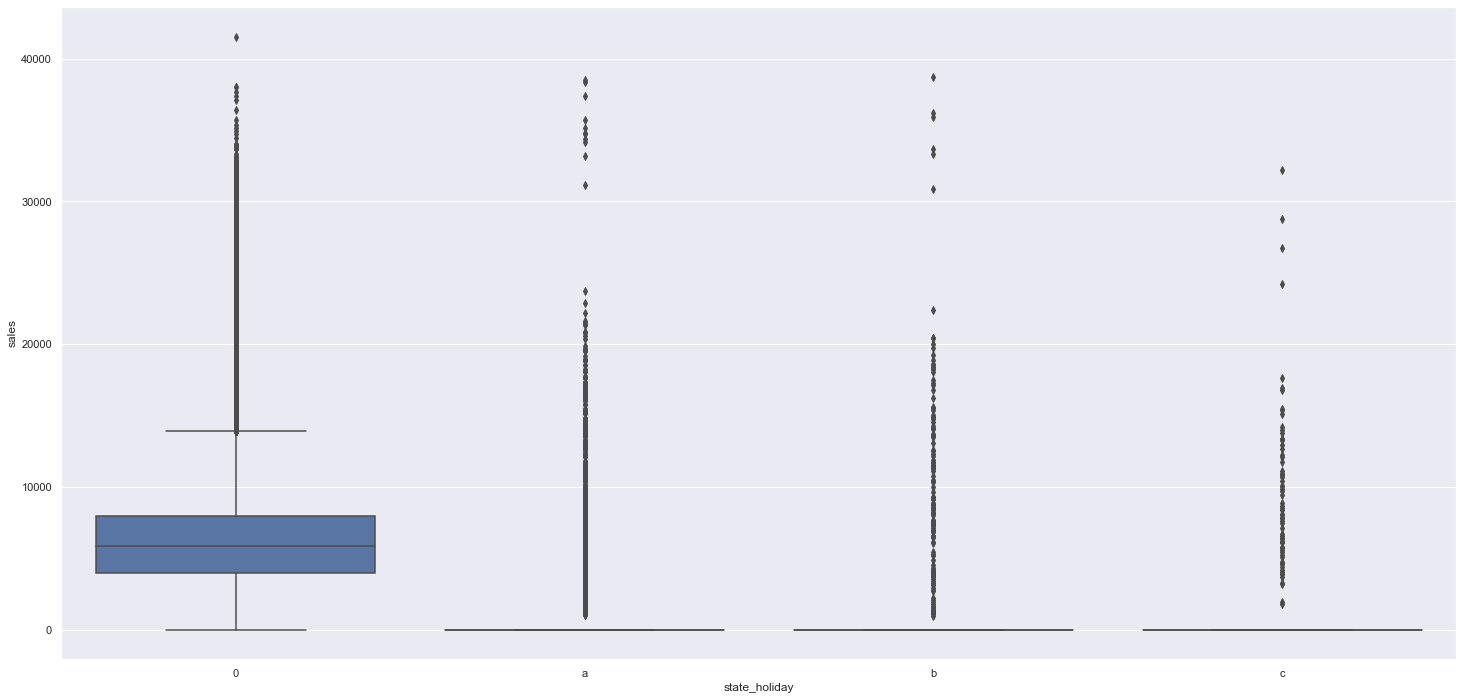

In [21]:
sns.boxplot( x= 'state_holiday', y='sales', data=df1);
#Its showing this way because it's shows all days, even the days that store is closed.

<AxesSubplot:xlabel='assortment', ylabel='sales'>

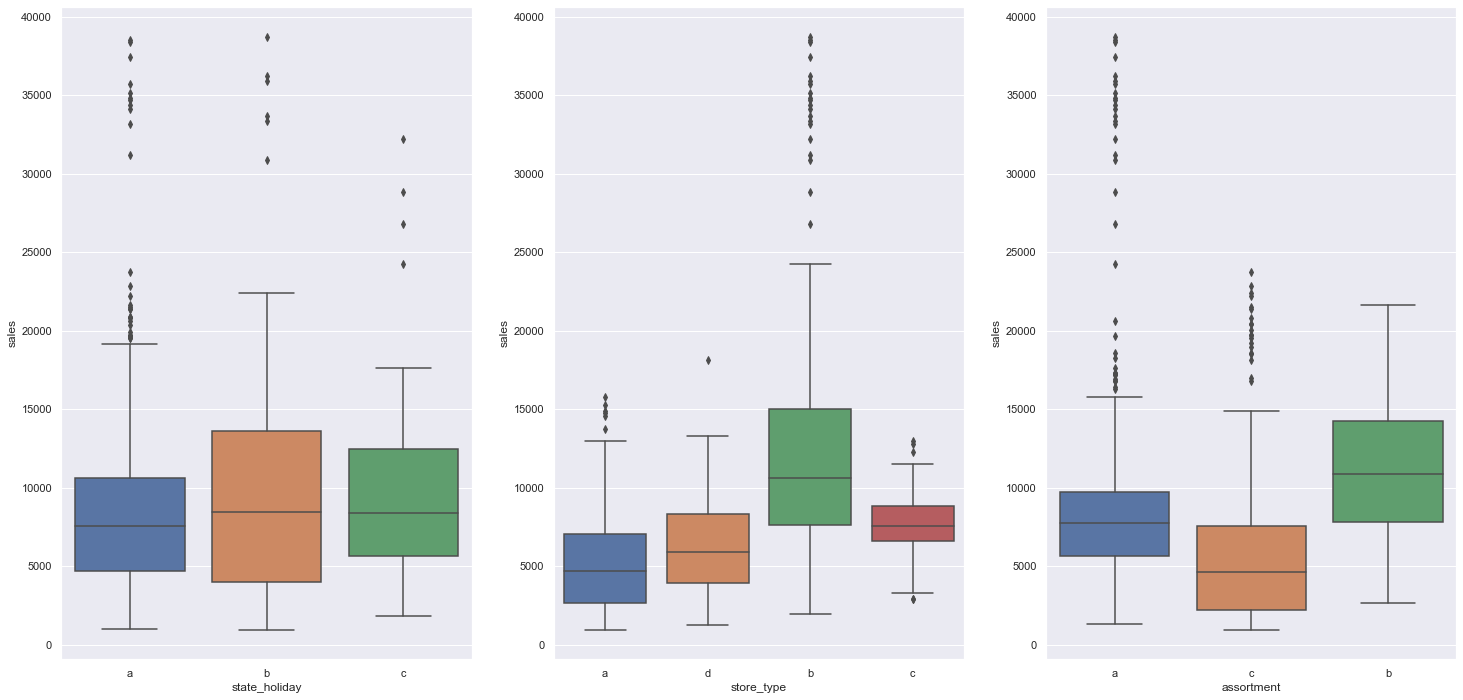

In [22]:
# We will filter this kind of cases to understand better the boxplot.

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot( x= 'state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot( x= 'store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot( x= 'assortment', y='sales', data=aux1)

Know it's mutch better to look and understand the boxplots. 
Here we can see some things:

- The state_holiday "b" has the bigger sales;
- The store_type "b" has a really different behavior. With more selling then the others types.
- The assortment "b" has a different behaviour too, with more sells. But the assortment 'a' has much more outliers then the others, it can be important try to discover why it happend.

# 2.0 Feature Engineering 

In [49]:
#Creating a copy of the last one section.

df2 = df1.copy()

## 2.1 Hypothesis

- Does we have the necessary data to accomplish the hypothesis?
    - How we are working with CRISP method, we will continue the work with the hypothesis that we can awnser. If in the end of this cycle the model don't performing as we wish and the variables would be importants, we need to restart the CRISP and collect more data to create new variables, trying to awnser more hypothesis.

### 2.1.1 Store Hypothesis

**1** - Stores with bigger assortments should sell more.

**2** - Stores with more closest competitors should sell less.

**3** - Stores with old competitors should sell more.

**4** - Stores with activate promotions for a long time should sell more.

**5** - Stores with more promotions days should sell more.

**6** - Stores with more consecutive promotions should sell more.

**7** - Stores opened in Christmas should sell more.

**8** - Stores should sell more over the time.

**9** - Stores should sell more in the second semester.

**10** - Stores should sell more after the day 10 of each month.

**11** - Stores should sell less in the weekend.

**12** - Stores should sell less in the scolar's hollidays.

## 2.2 Feature creation

In [50]:
# Year
df2['year'] = df2['date'].dt.year
# Month
df2['month'] = df2['date'].dt.month
# Day
df2['day'] = df2['date'].dt.day
# Week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# Year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# Competition sice
## calculation the time between two different datas.
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis = 1)
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] ) / 30).apply(lambda x: x.days).astype('int64')

# Promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] ) / 7).apply(lambda x: x.days).astype('int64')

# Assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [51]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 3.0 Variable Filtering

In [53]:
#Creating a copy of the last one section.

df3 = df2.copy()

Difference between **Variable Filtering** and **Variable Selection**:

- Variable Filtering:
    - Business Restrictions;
        - Exist variables that even if we put then on models, they will not perfom better.
        
        
- Variable Selection:
    - Most impactant variables for the model;

## 3.1 Line Filtering

- The column "open" is not important, because in this days the value of sell will be 0.
- "sales" need to be more then 0.

In [54]:
df3 = df3[(df3['open'] != 0)&(df3['sales'] > 0)]

## 3.2 Column Filtering

- The column "customers" tells about the client was in store on that day. If we need preview the clients for each months, this will be a different project. Because of this, we will not use this column.
- How the column open was filtered, we don't need to use it know.

In [55]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0 Exploratory Data Analysis (EDA)

In [56]:
#Creating a copy of the last one section.

df4 = df3.copy()

In EDA we have three extremely important aspects:

- Gain experience about the business.
- Validate business hypothesis to generate hypothesis.
- Discover important variables for the model.


We use three analysis.
- Univariate Analysis
    - Discover the limits.
    - Max, min, distribution;
    
- Bivariate Analysis
    - How this variable impact our response?
    - Correlation;
    
- Multivariate Analysis
    - Look to more then just one variable impacting our response.
    - How they relate to each other?
    - What is the correlation between them?

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

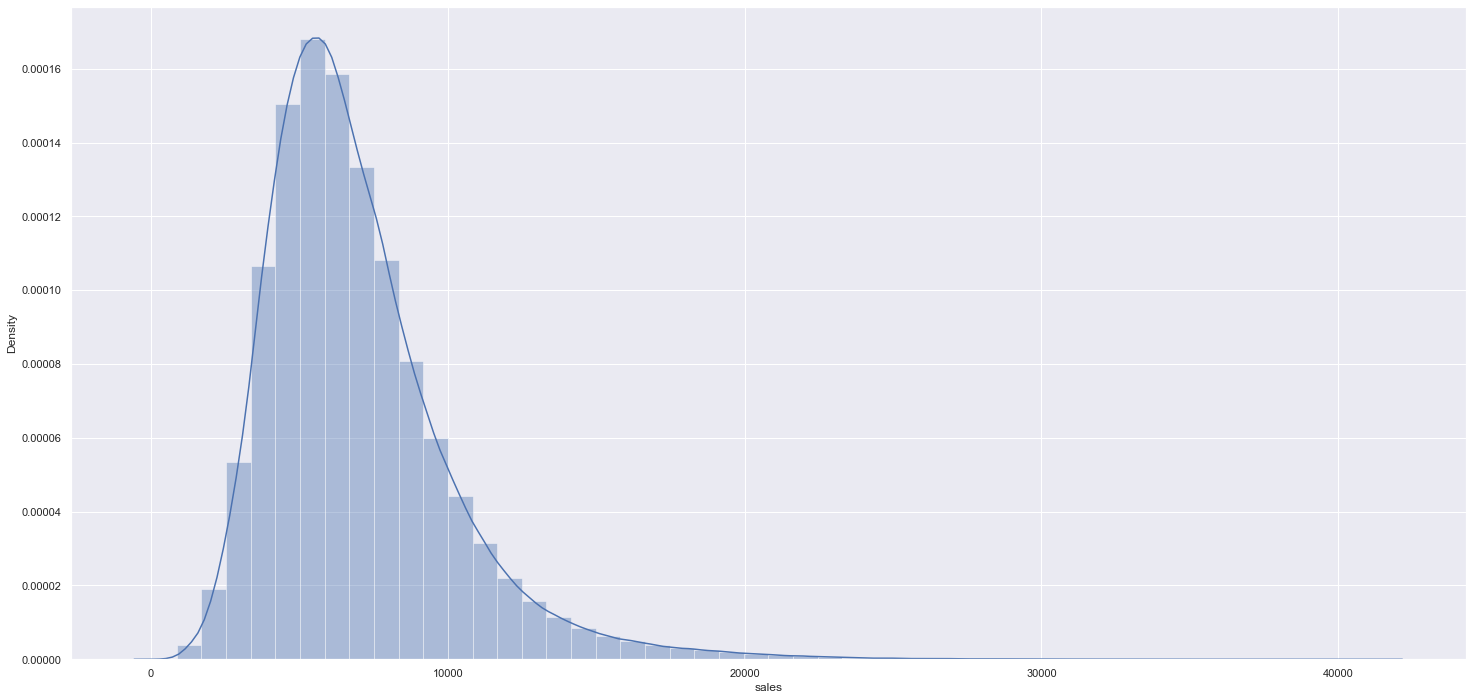

In [57]:
sns.distplot(df4['sales']);

### 4.1.2 Numerical Variable

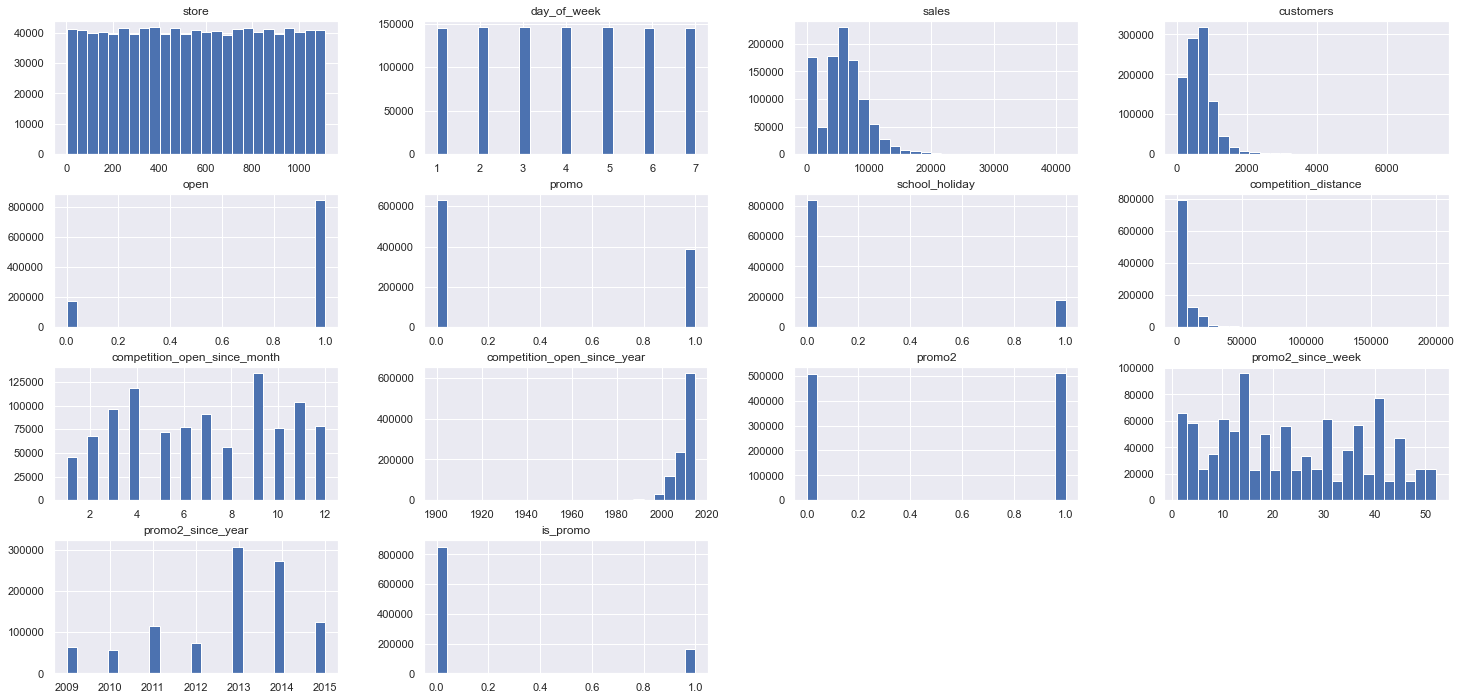

In [58]:
num_attributes.hist(bins = 25);

### 4.1.3 Categorical Variable

In [59]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


<AxesSubplot:xlabel='sales', ylabel='Density'>

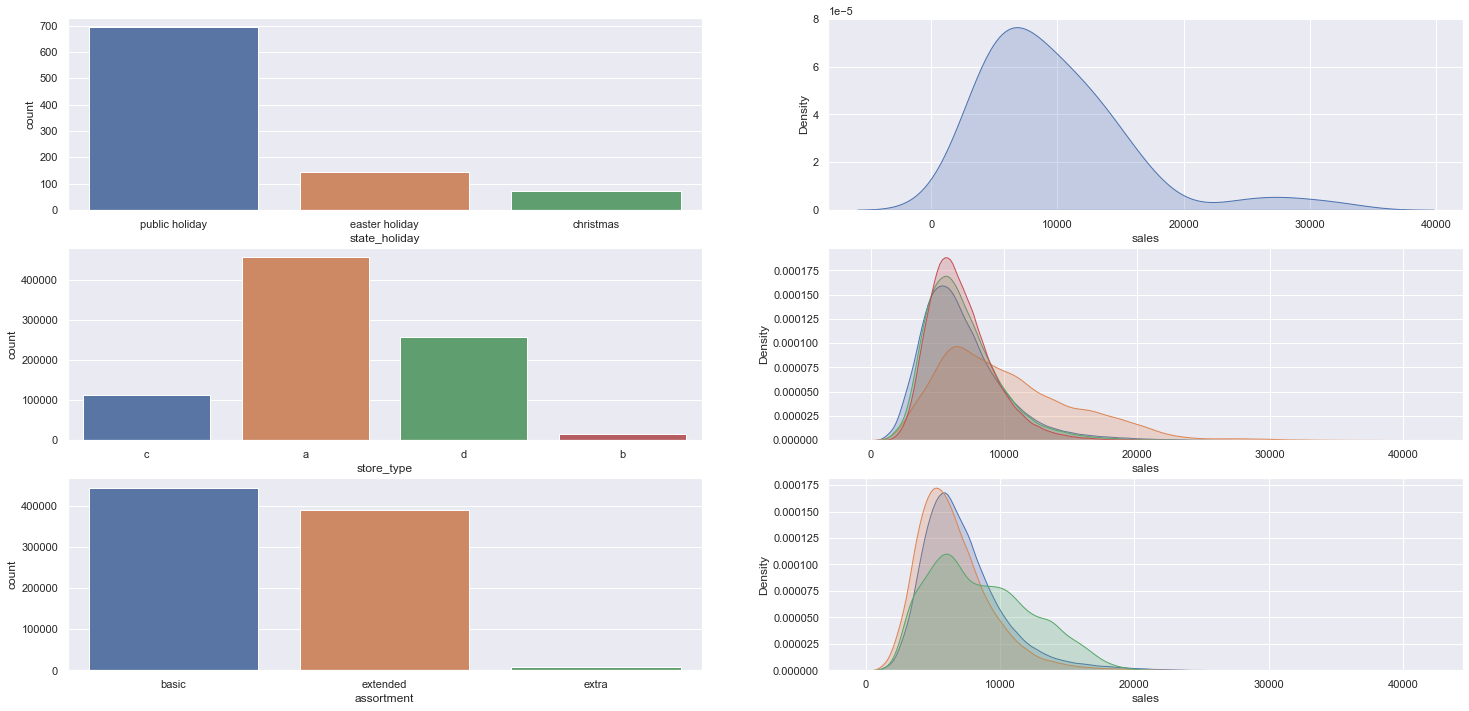

In [61]:
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)


#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2 Bivariate Analysis

### **1** - Stores with bigger assortments should sell more.
***True*:Stores with bigger assortments really sells more then the others two types.**

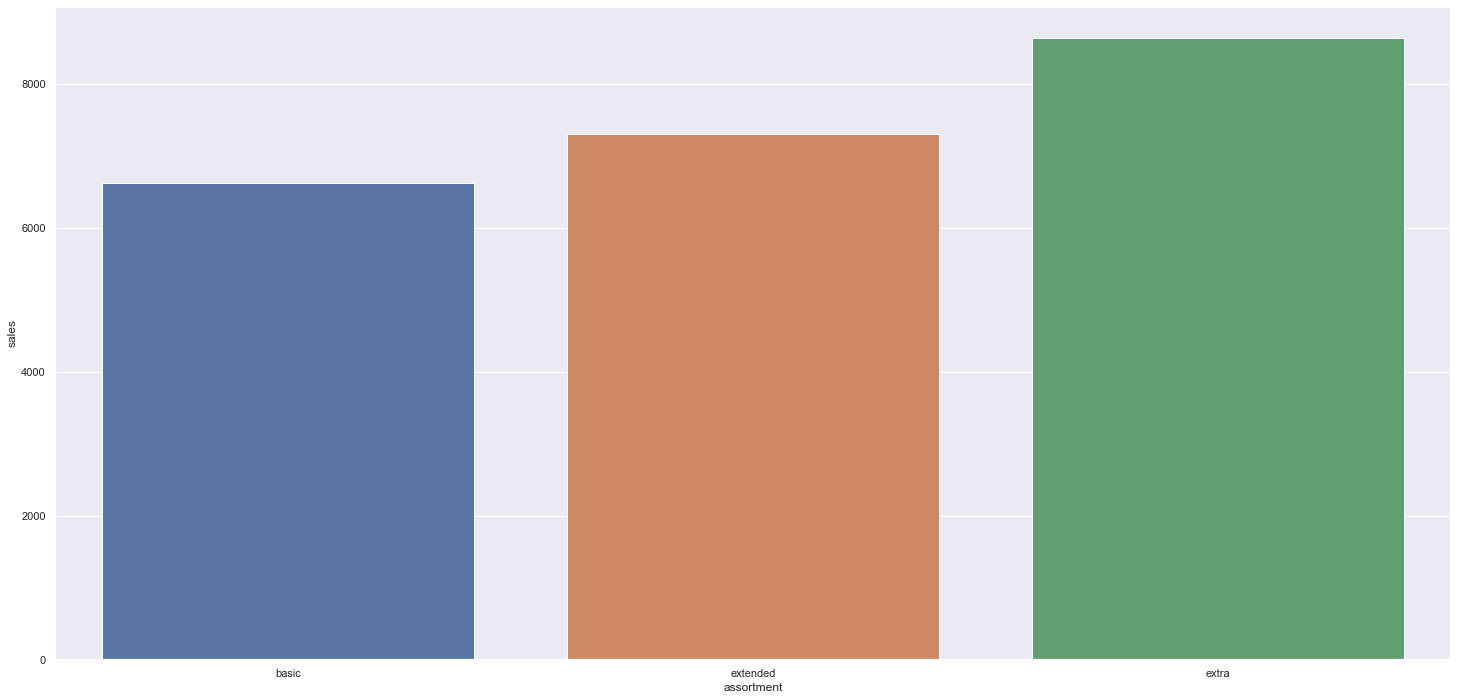

In [34]:
aux1 = df4[['assortment','sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

We gonna see the variation throught the time of each one assortment.

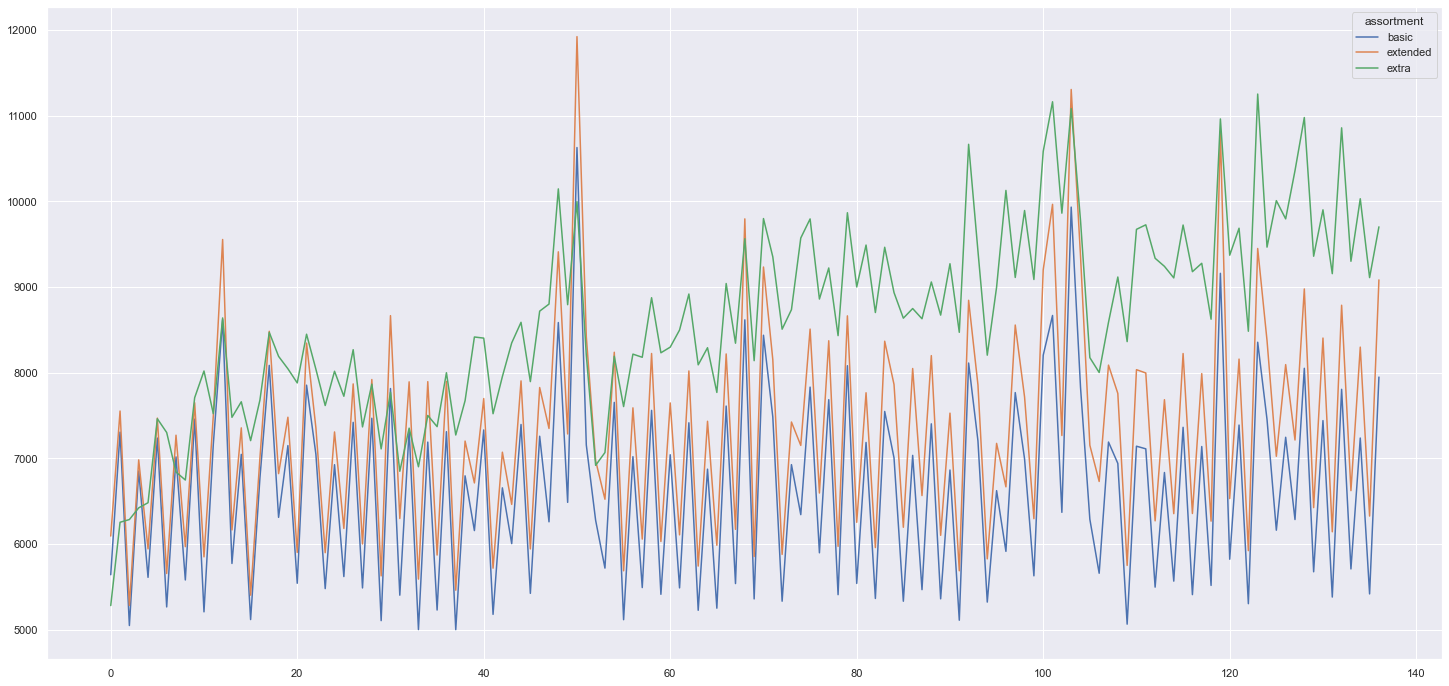

In [35]:
aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2.pivot(index='year_week',columns='assortment',values='sales').reset_index().plot();

### **2** - Stores with more closest competitors should sell less.
***False*: There is no evidence that the fact that there are closer competitors will impact the fact of selling more or less.**

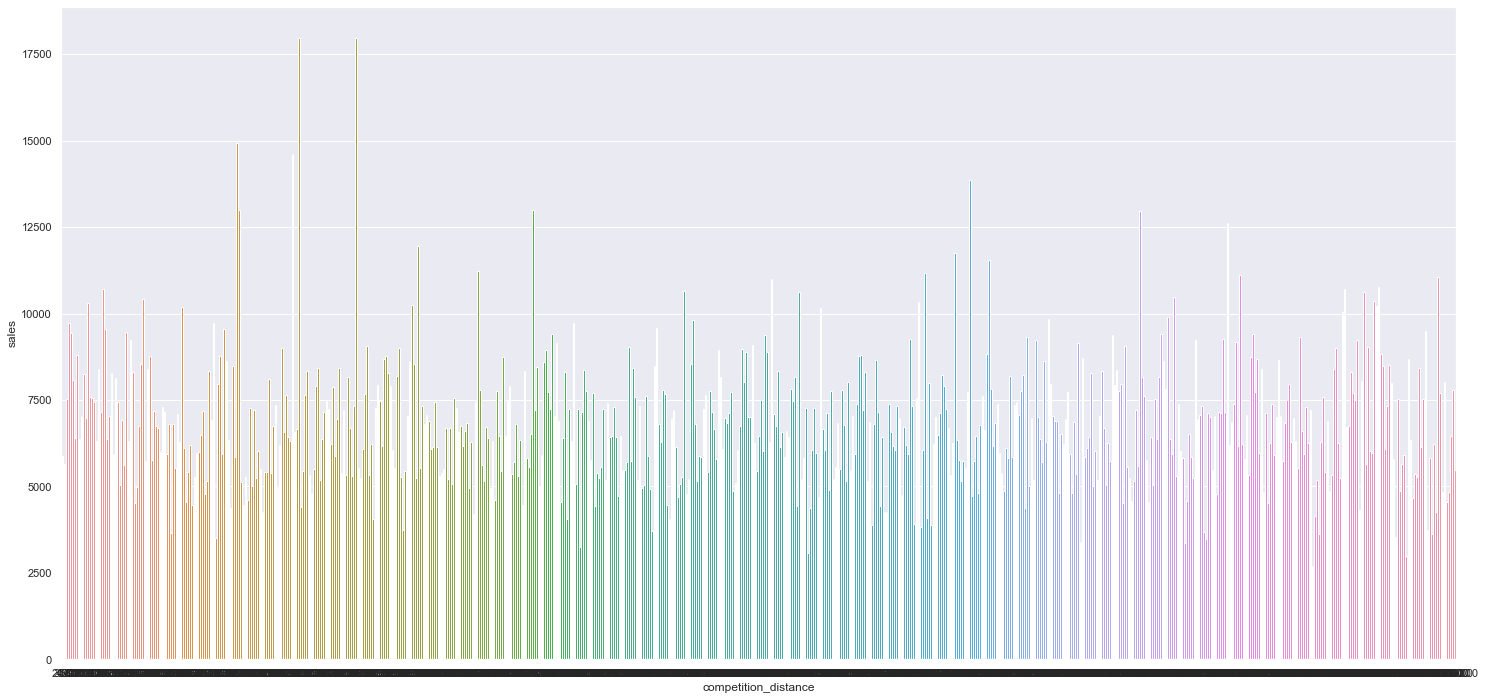

In [62]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
sns.barplot(x='competition_distance', y='sales', data=aux1);

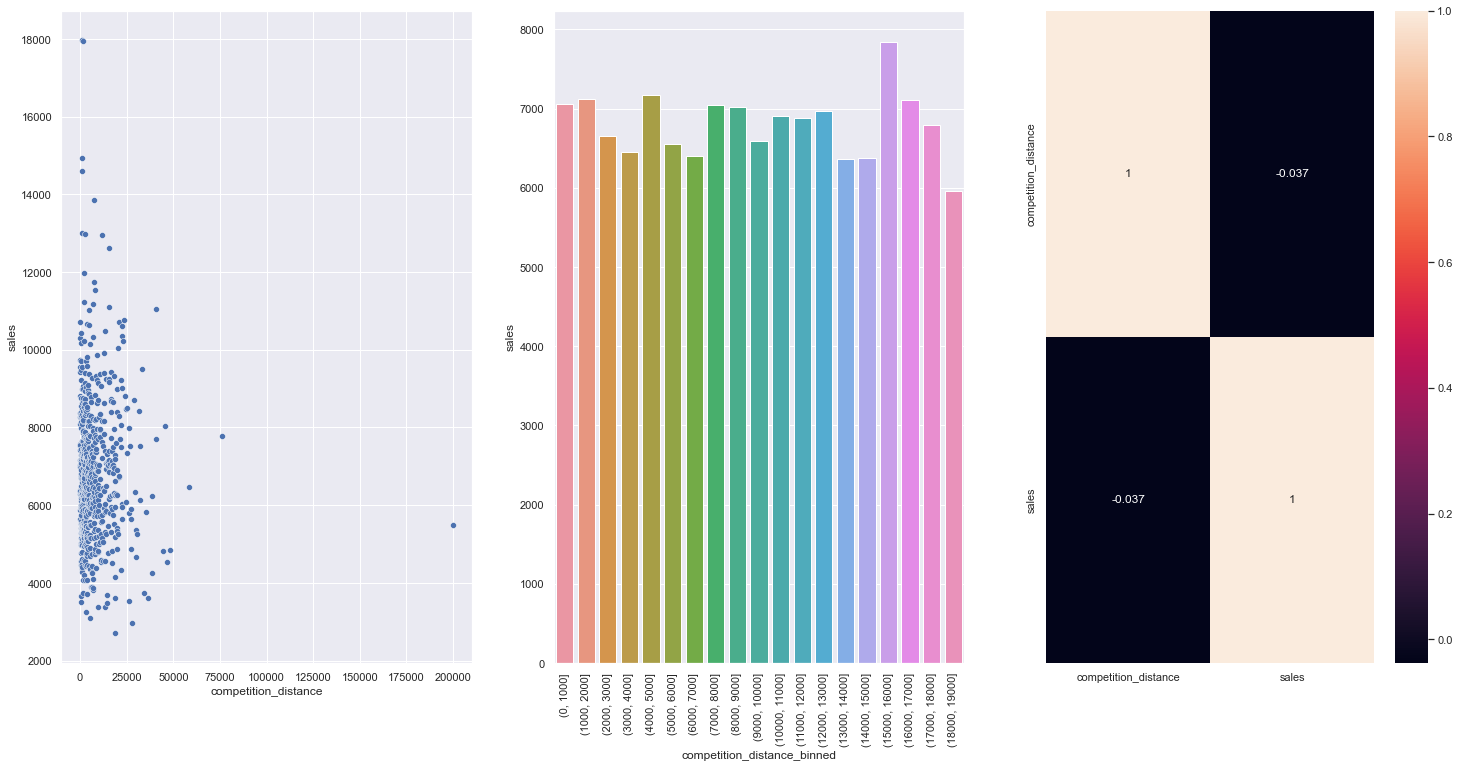

In [63]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

This is an important information. The commum sense says that if we have competitors, we will share the customers with other stores, although as we see in this graph, the behaviour is opposite, the stores that has competitors close are selling more.

### **3** - Stores with old competitors should sell more.
***False*: In the true, as far more the time of has competitor in place, lower are the number of sellings. When the competitors are to enter in the business, this is the moment that has more selling.**

<AxesSubplot:xlabel='competition_open_since_month', ylabel='sales'>

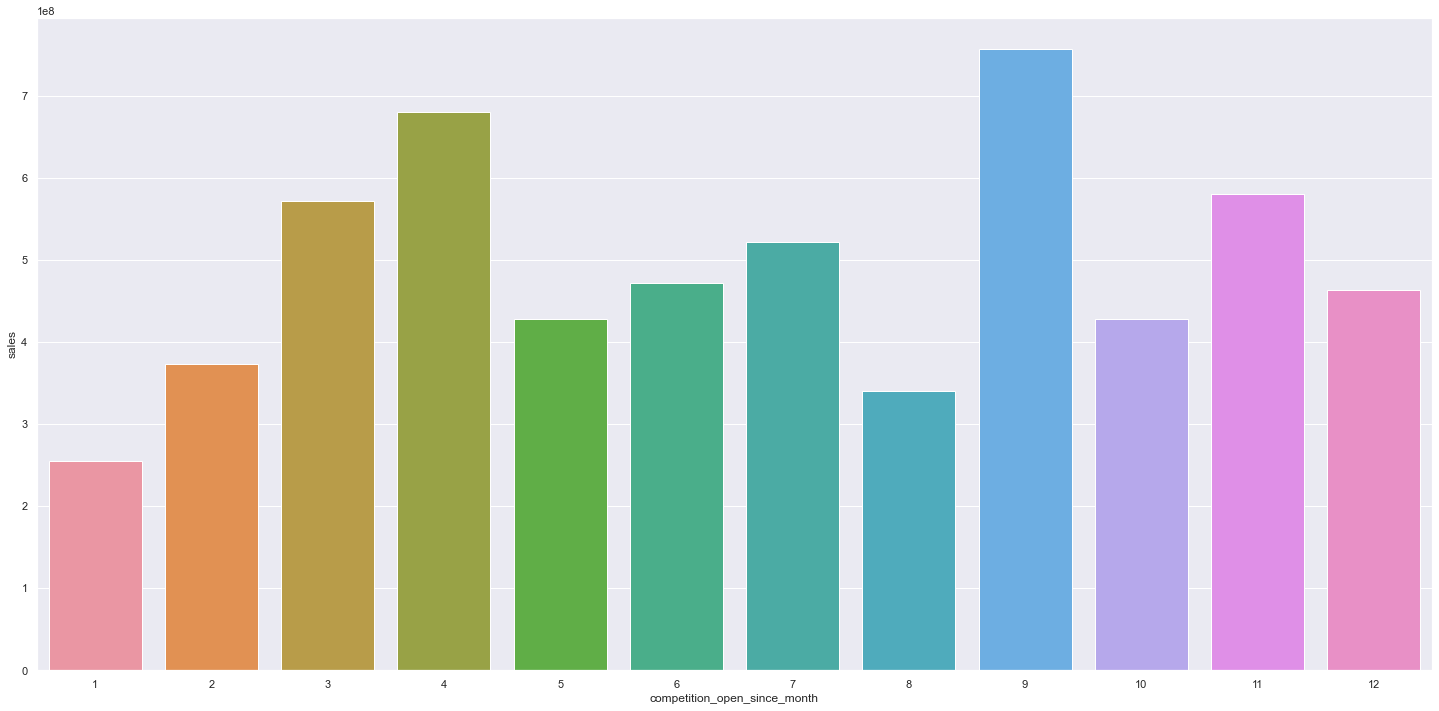

In [146]:
aux1 = df4[['competition_open_since_month','sales']].groupby('competition_open_since_month').sum().reset_index()
sns.barplot(x='competition_open_since_month', y='sales', data=aux1)

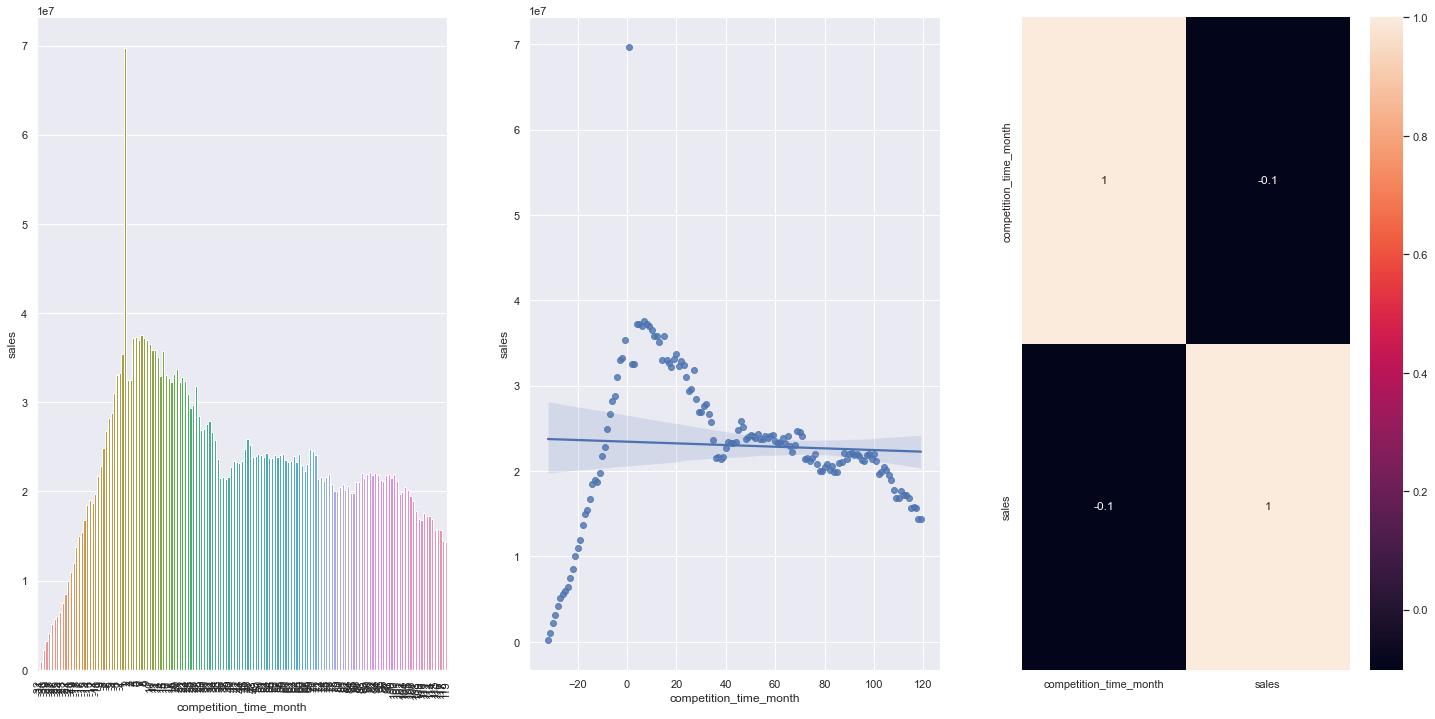

In [147]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120)&(aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

The result of hypothesis are false, but we discover an important feature to the model, with a correlation not so close to 0.

### **4** - Stores with activate promotions for a long time should sell more.
***False*: Store with promo activate for a long time sell less after some time.**

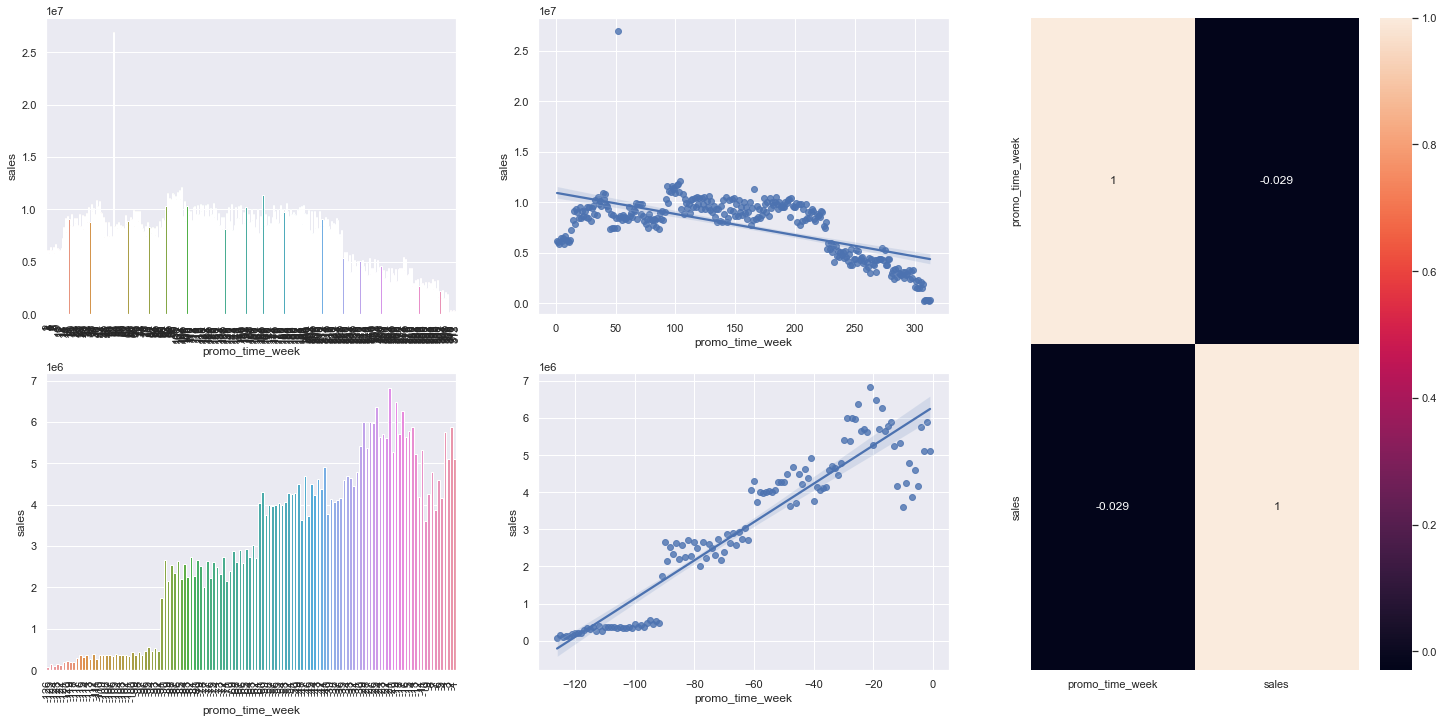

In [66]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot(x='promo_time_week', y='sales', data=aux1);

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #extended period
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation = 90);


plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);


plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #standard period
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);


plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

The extended promo has a limit time to sell more. After this period doesn't work more and the number of sells start to fall.

In the regular period, the number of sells are bigger in the start of period. 

As we have a small correlation (very near to 0), this feature won't be good for our ML model.

### **5** - Stores with more promotions days should sell more.
***False*: We alredy know that the promo active for a long time don't works so good, so this hypothesis will not be true.**

### **6** - Stores with more consecutive promotions should sell more.
***False*: Store with more consecutive promotions sell less products.**

In [149]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


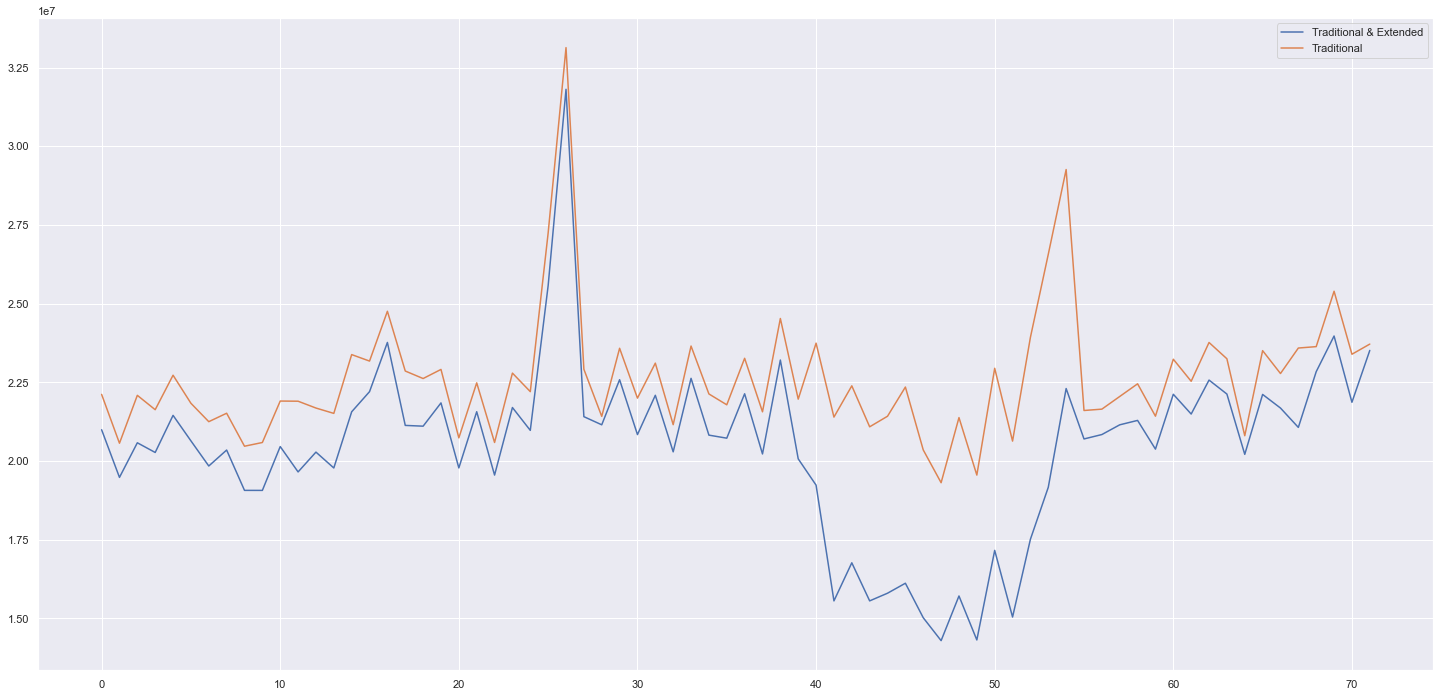

In [150]:
aux1 = df4[(df4['promo'] == 1)&(df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1)&(df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels = ['Traditional & Extended','Traditional']);

### **7** - Stores opened in Christmas should sell more.
***False*: Stores opened in christmas don't sell more. But historically this behaviour is improving. In the year of 2014 the mean of sells in christmas overcame the mean of sells in the others hollidays. It could represent some important information.**

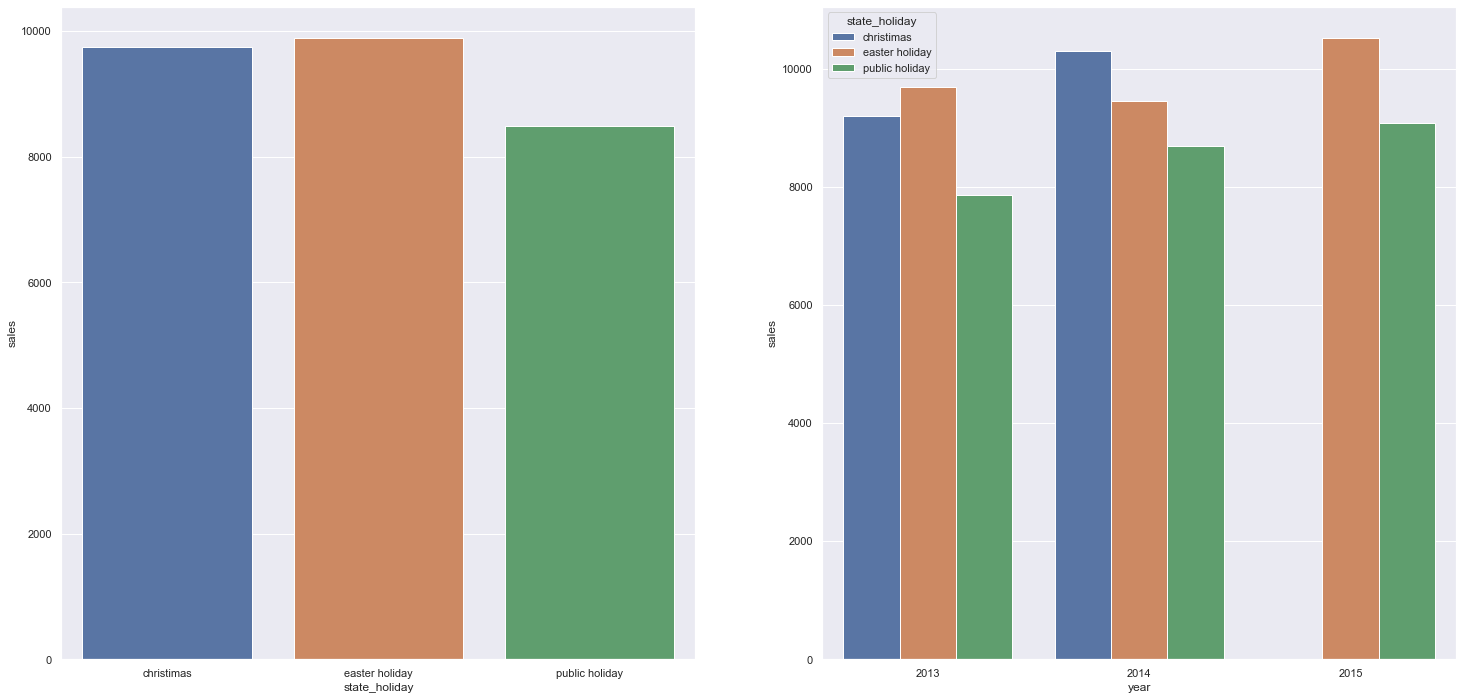

In [151]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **8** - Stores should sell more over the time.
***False*: In the year of 2013 - 2014 the selles decreased. The year of 2015 isn't complete, so we cannot claim this fact.**

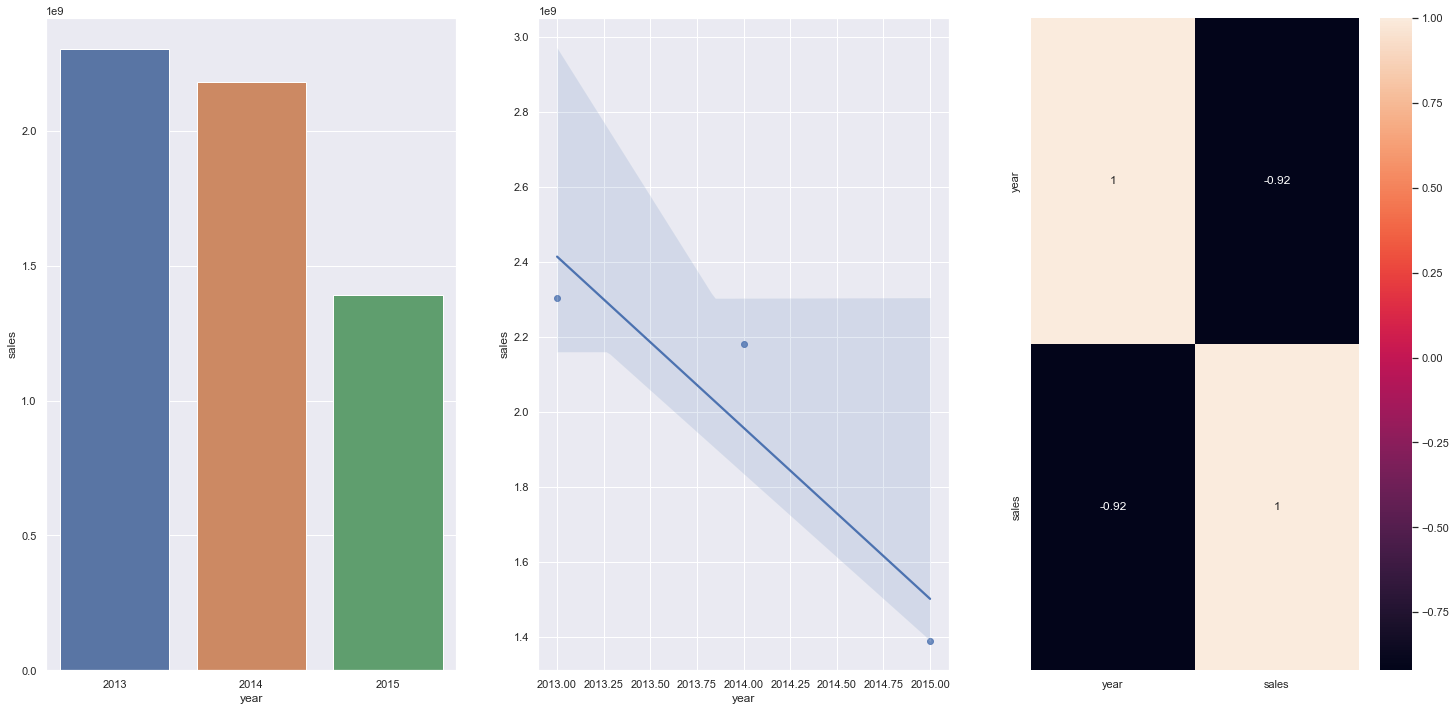

In [152]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

It's a very strong negative correlation, this happen because the year of 2015 isn't complete. So we gonna see it only with the complete years.

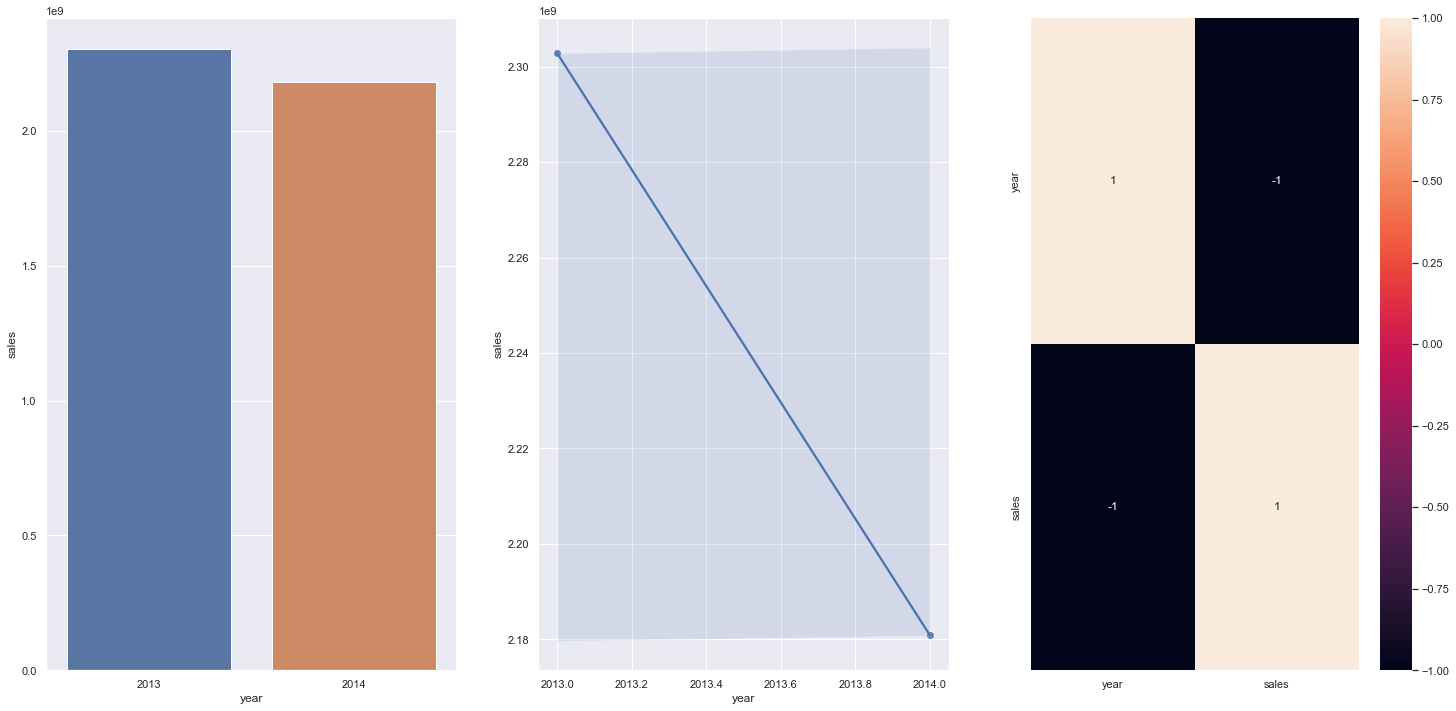

In [153]:
df4a = df4[df4['year'] != 2015]
aux1 = df4a[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **9** - Stores should sell more in the second semester.
***False*: The stores sell less in second semester of year.**

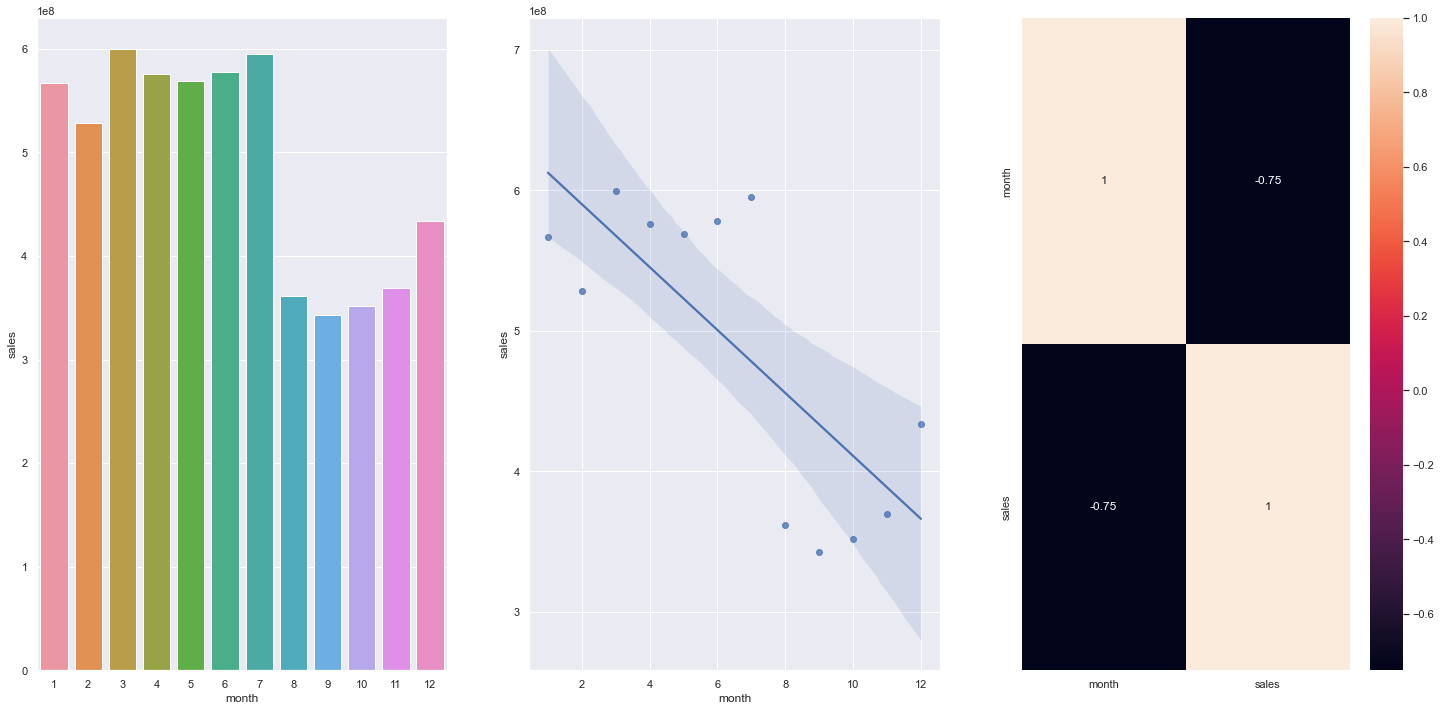

In [154]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **10** - Stores should sell more after the day 10 of each month.
***False*: The stores don't has a bigger mean of salles after the 10 first days.**

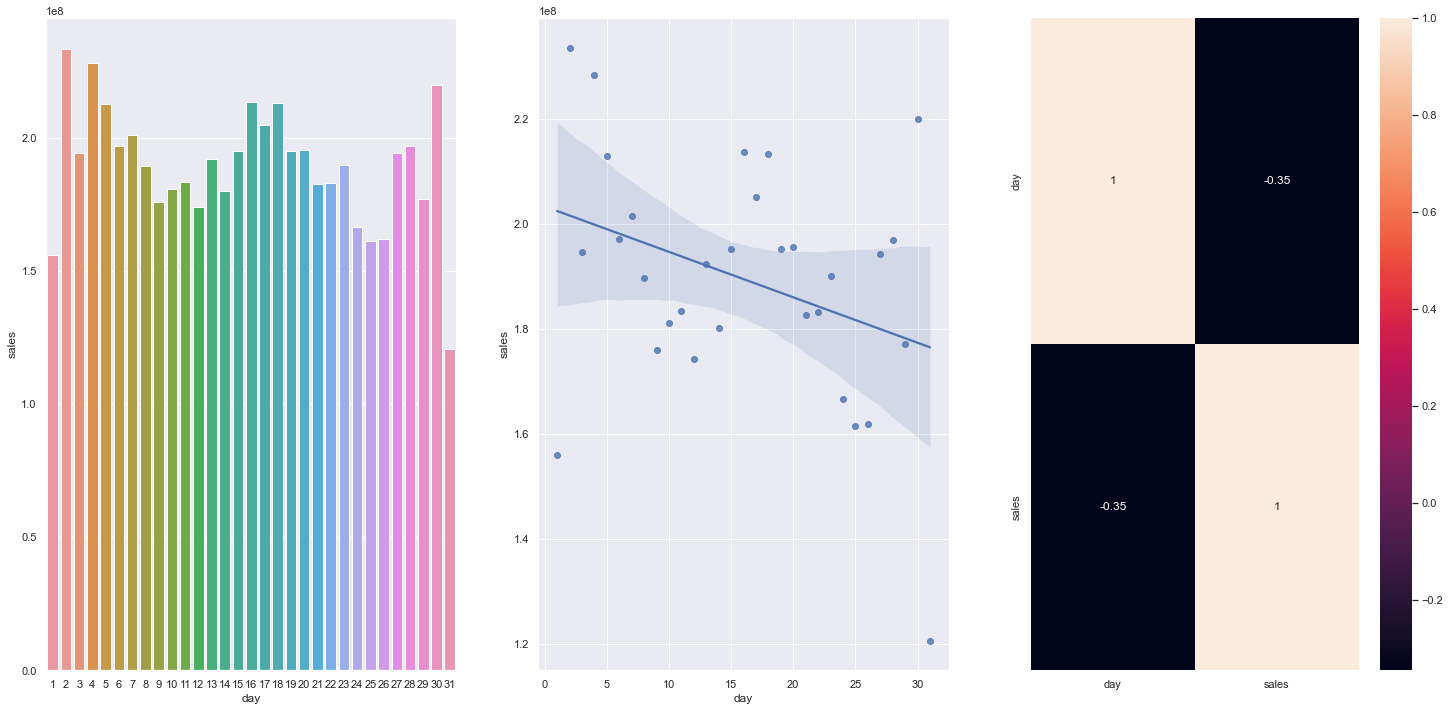

In [155]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

To validate the hypothesis, we need analyze until the 10 day and after it.

In [156]:
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

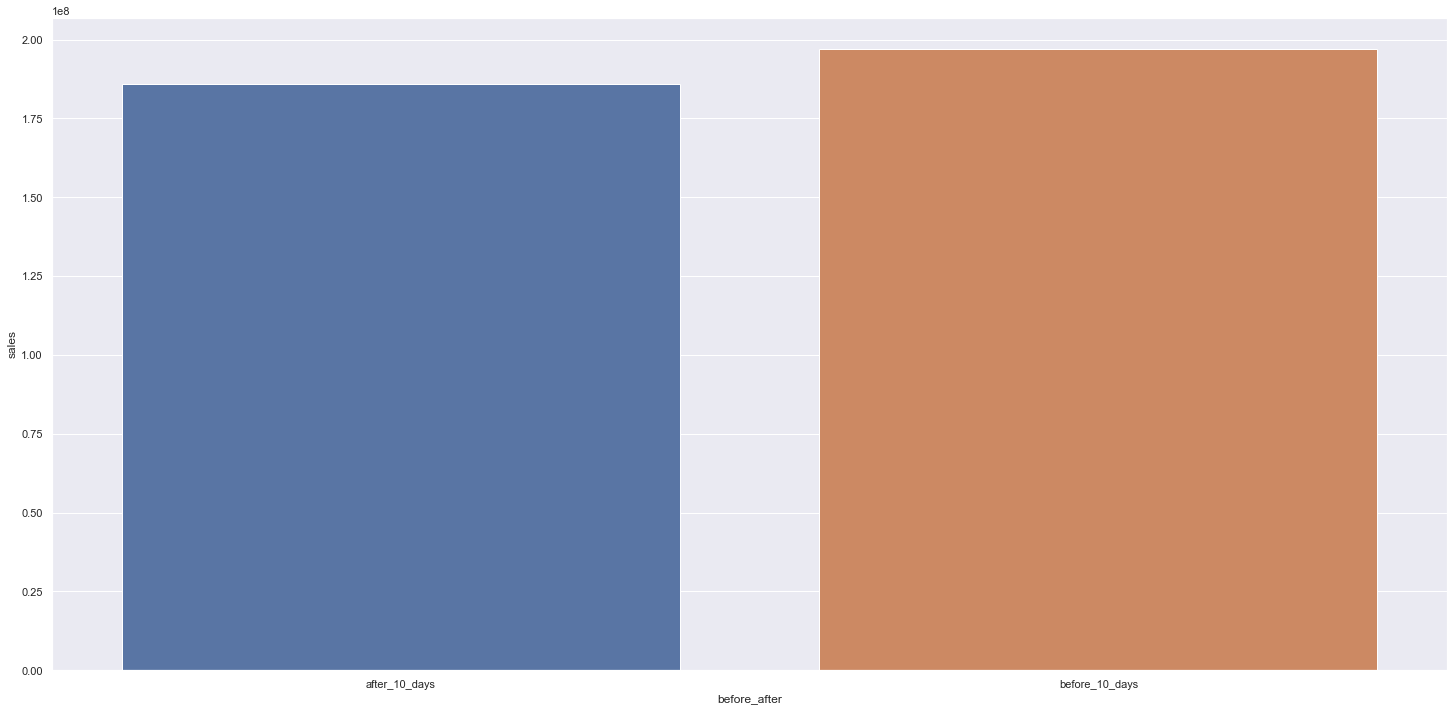

In [157]:
aux2 = aux1[['before_after','sales']].groupby('before_after').mean().reset_index()
sns.barplot(x='before_after',y='sales', data=aux2);

### **11** - Stores should sell less in the weekend.
***True*: The stores sell less in the weekend, especially in sunday.**

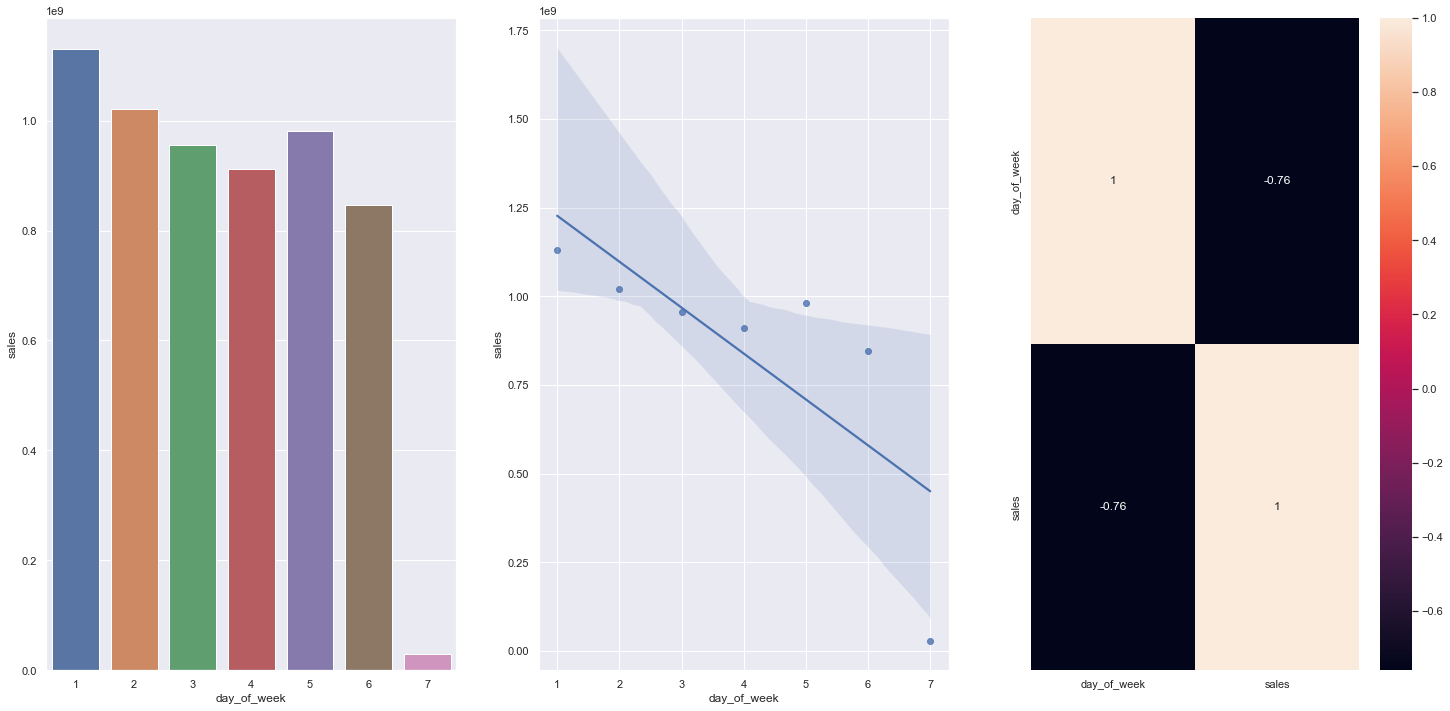

In [158]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **12** - Stores should sell less in the scolar's hollidays.
***False*: The mean of sells are bigger for the scolar's hollidays. The behaviour of each month is almost the same, only changing it in december.**

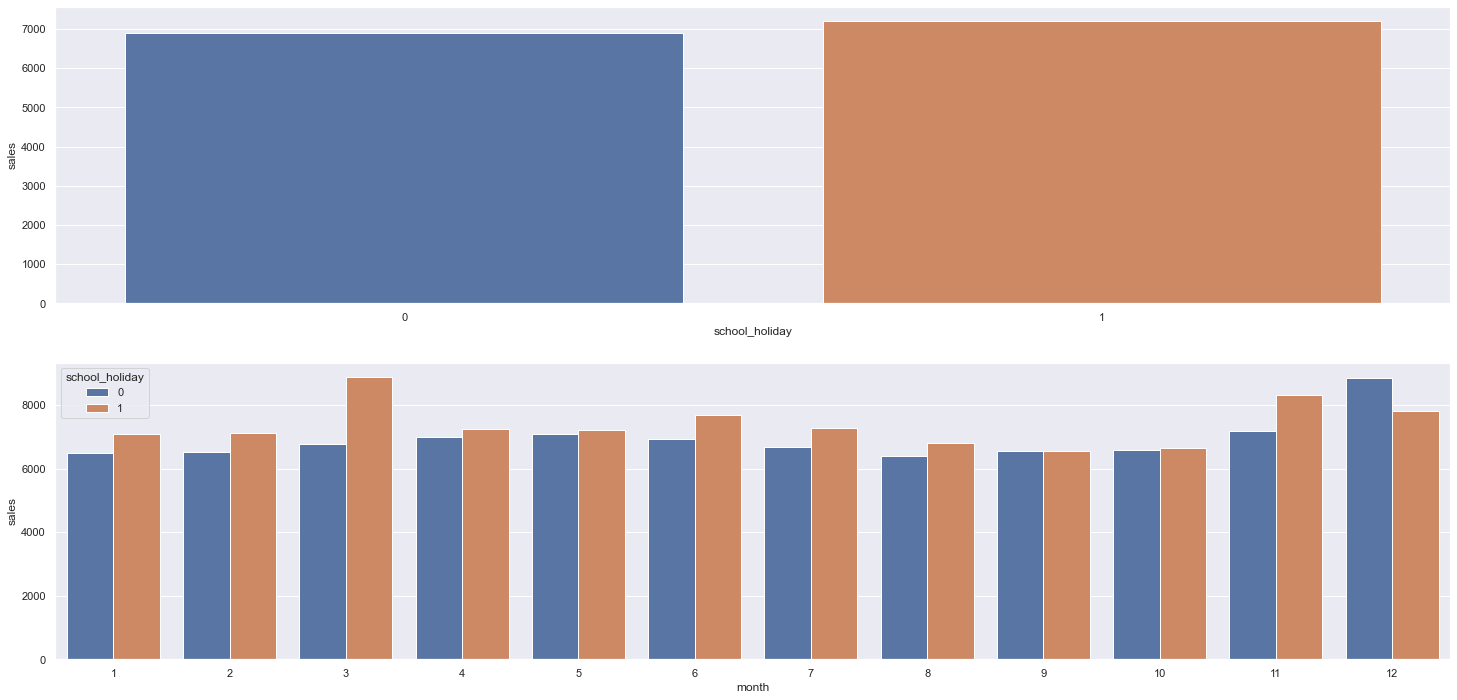

In [159]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).mean().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

## 4.3 Hypothesis report

In [160]:
tab = [['Hipoteses','Conclusao','Relevancia'],
      ['H1','True','High'],
      ['H2','False','Medium'],
      ['H3','False','Medium'],
      ['H4','False','Low'],
      ['H5','False','Low'],
      ['H6','False','Low'],
      ['H7','False','Medium'],
      ['H8','False','High'],
      ['H9','False','High'],
      ['H10','False','High'],
      ['H11','True','High'],
      ['H12','False','Low']]

print( tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           True         High
H2           False        Medium
H3           False        Medium
H4           False        Low
H5           False        Low
H6           False        Low
H7           False        Medium
H8           False        High
H9           False        High
H10          False        High
H11          True         High
H12          False        Low


## 4.4 Multivariate Analysis

Machine Learning algorythm follow some premises. One of them are to always chose the model less complexe to use. 
One way to transform a model in a model less complexe is about the dimensionality.
As more columns that we have in model, more complexe it will be. 
So, to transform it we need remove some columns, to remove some columns, we need to discover how they behave with each one. 

### 4.4.1 Numerical Attributes

In [161]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


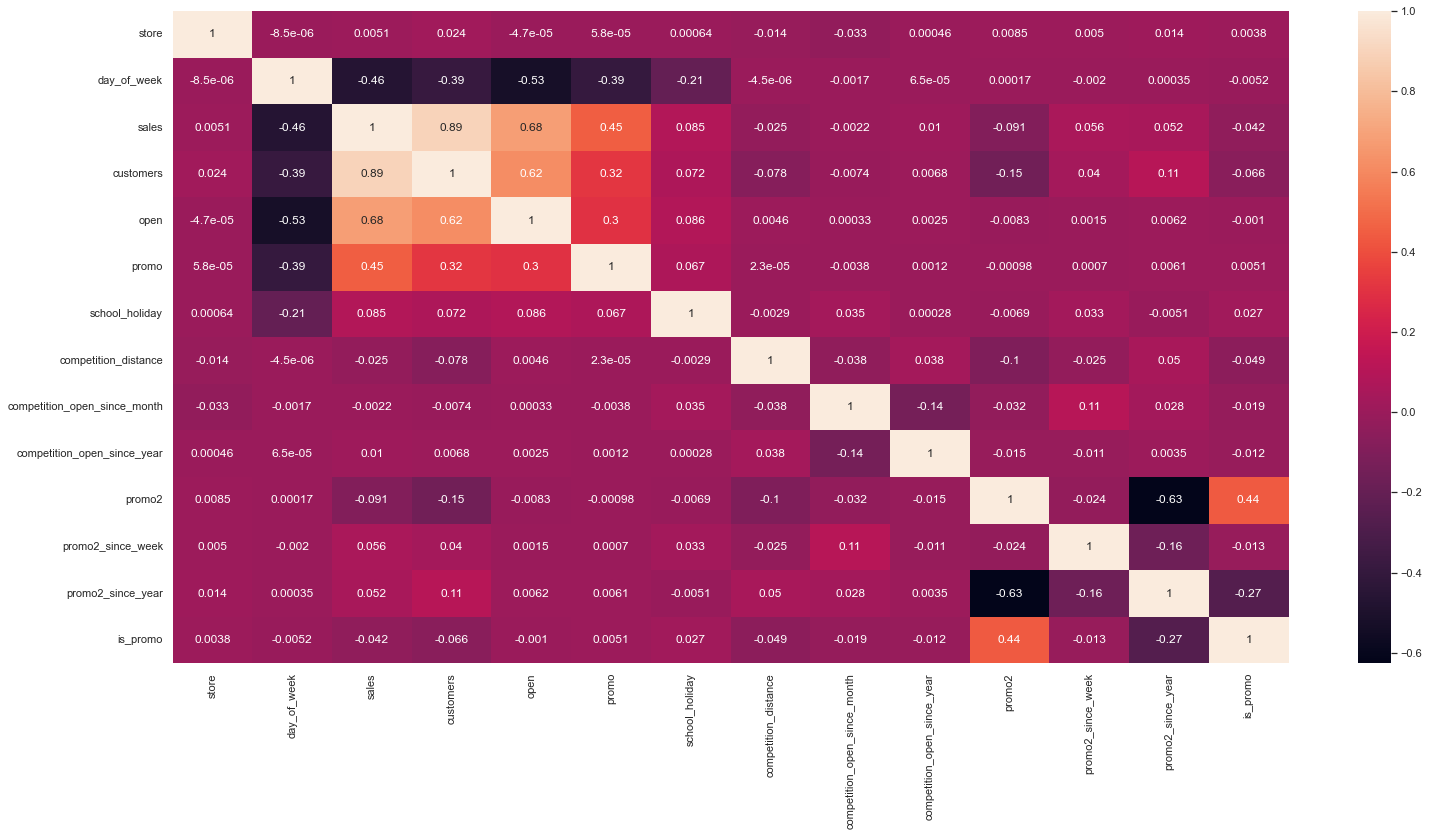

In [162]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

We can see the column called "customers" that has a good correlation with sales, but we can't use it. In daily basis we will not have the information about how much clients will be in our store. 

### 4.4.2 Categorical Attributes

To calculate the correlation about categorical data, we will use the cramer v test.

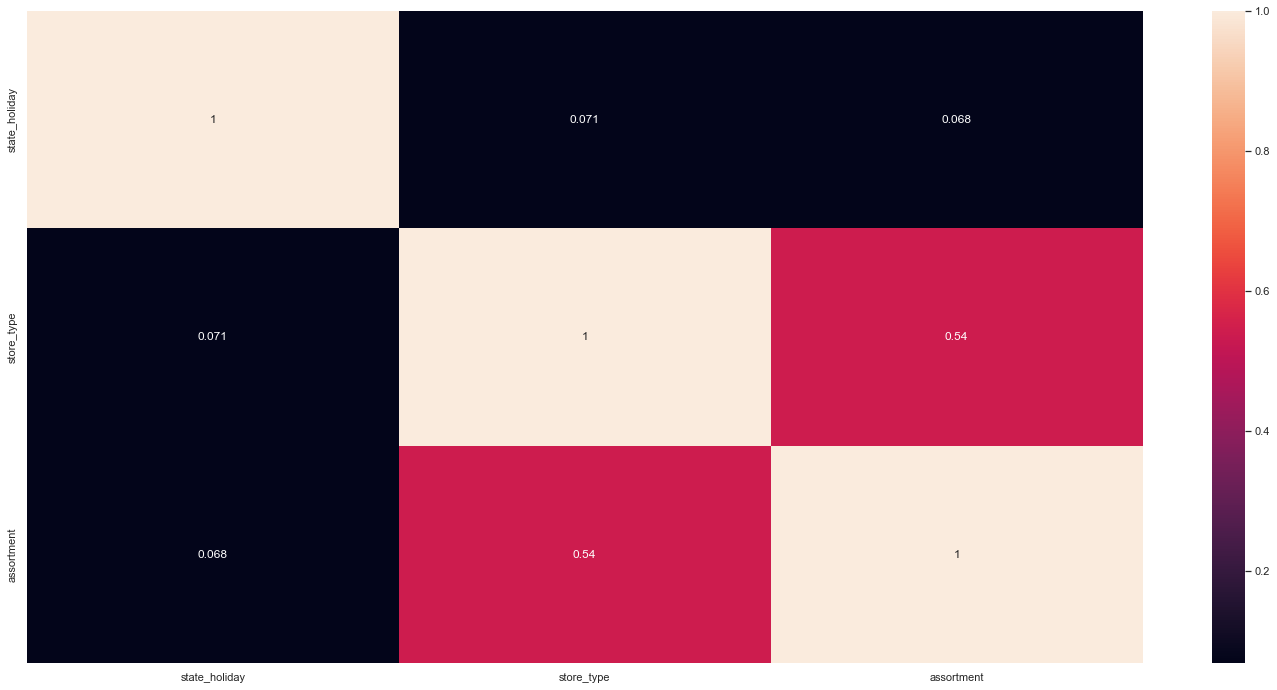

In [163]:
#Only categorical data
a = df4.select_dtypes(include='object')

#Calculate cramer_v
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

#final dataset
d = pd.DataFrame( {'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9]})
d = d.set_index(d.columns)
d

#creating heatmap
sns.heatmap(d, annot=True);

# 5.0 Data Preparation

In [68]:
#Creating a copy of the last one section.

df5 = df4.copy()

The larning of ml algorythm it's more easier with numerical data, all of them in the same scale. 

One problem that we have is about the data standardzation, for exemple, the days of the week range from 1 to 7, as the competitors distance range from 20 to 200000. This difference prevail the mistakes.

Here we gonna use three different preparation:
- Normalization:
    - Will reescaling the center to 0 and the std to 1.
    - Goes well with variables with normal distribution.
    
    
- Rescaling:
    - Reescaling values between 0 and 1.
    - Goes well with variables that hasn't normal distribution.
    
    
- Transformation:
    - Categorical attributes to numerical attributes.
    - Nature transformation - In variables that has cicle format. Like months, days.

## 5.1 Normalization

We will not use Normalization.

## 5.2 Rescaling

In [69]:
a = df5.select_dtypes(include = ['int64','float64'])

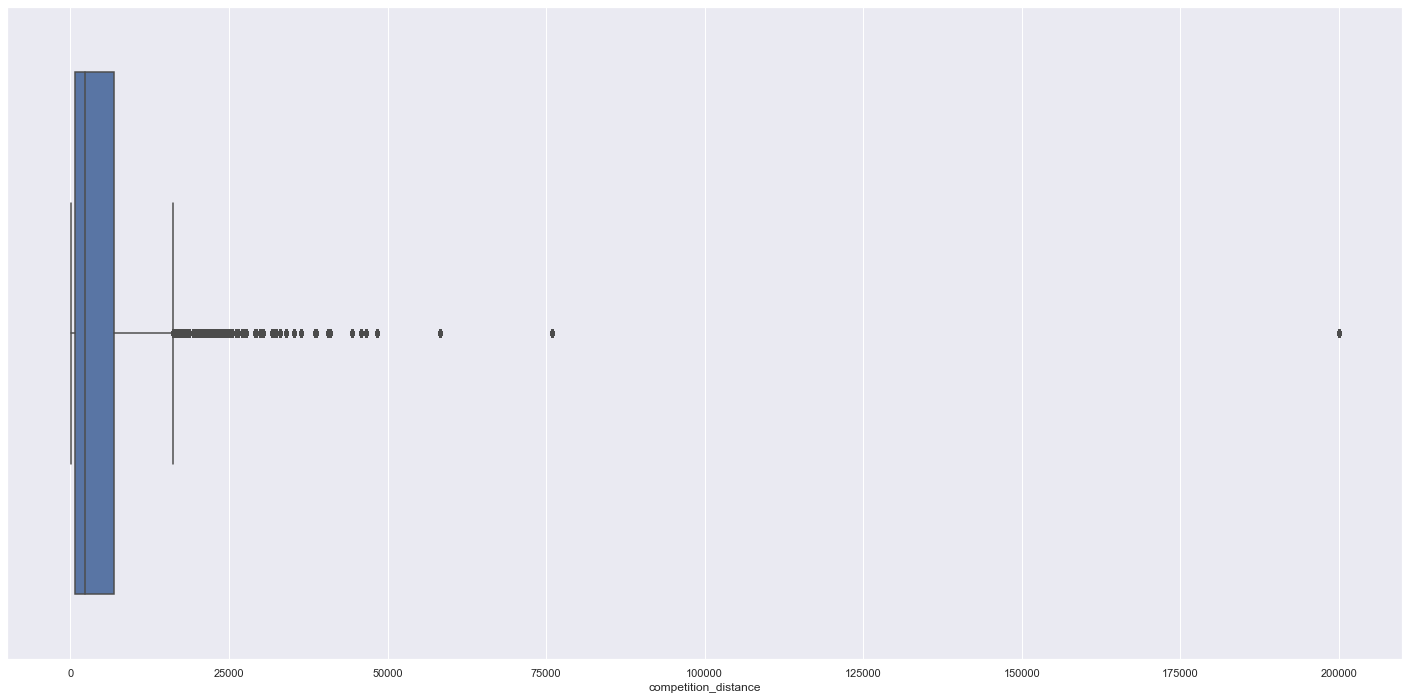

In [70]:
sns.boxplot(df5['competition_distance']);

#We have big outliers in 'competition_distance'

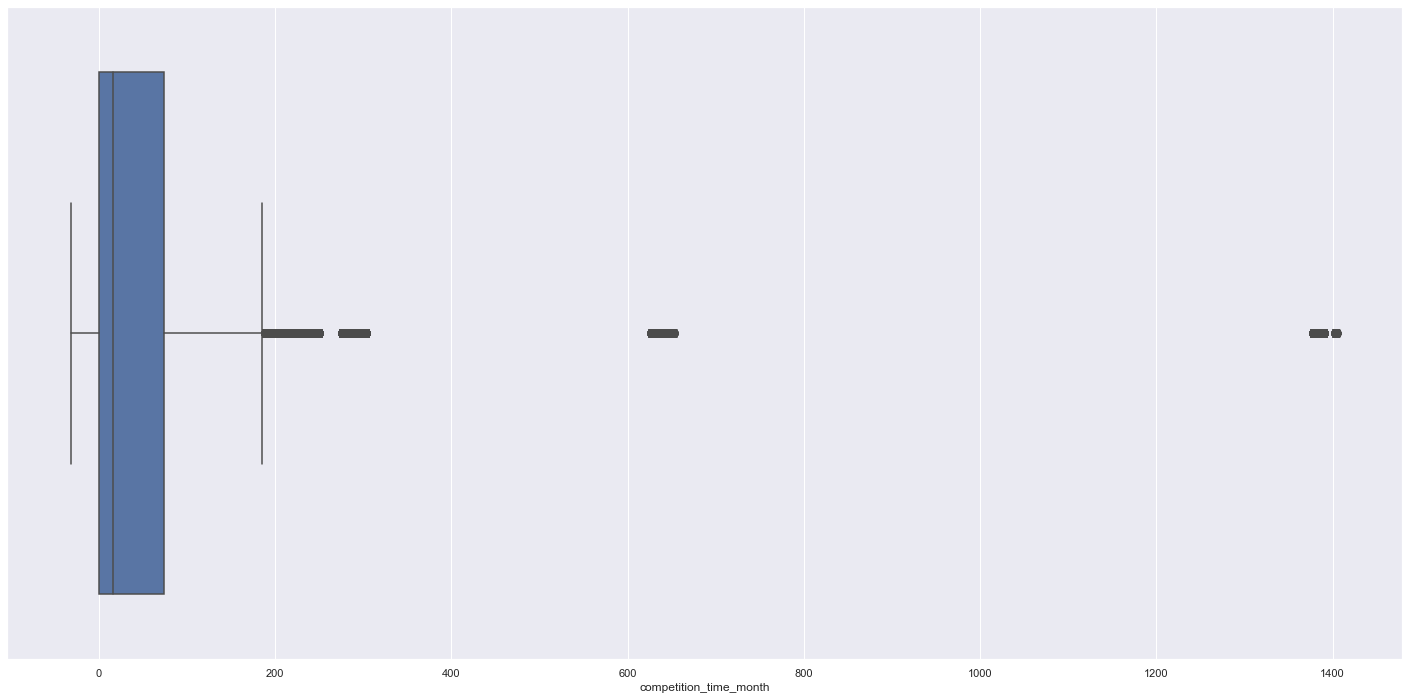

In [71]:
sns.boxplot(df5['competition_time_month']);

#We have big outliers in 'competition_time_month'

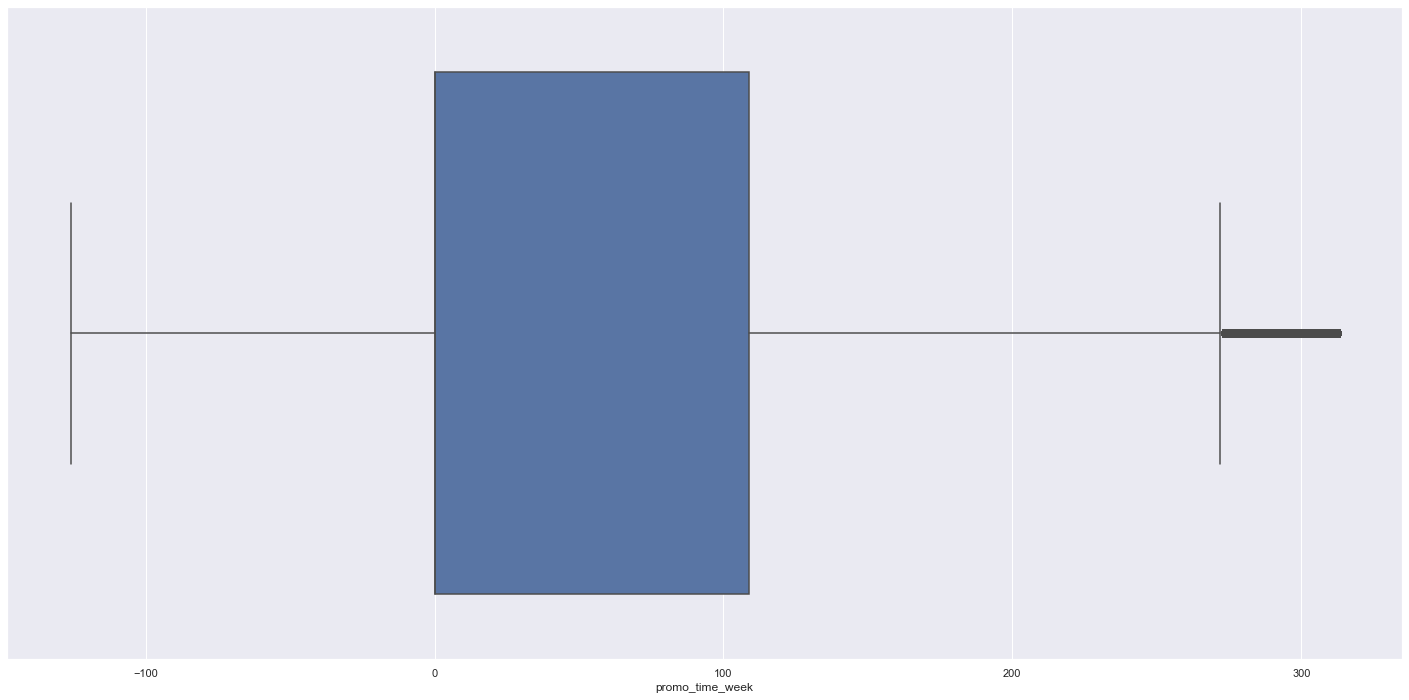

In [72]:
sns.boxplot(df5['promo_time_week']);

#We don't have relevant outliers, so we will use the 'min-max scaler'

In [73]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance (Robust scaler)
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )

# year
df5['year'] = mms.fit_transform(df5[['year']].values )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values )

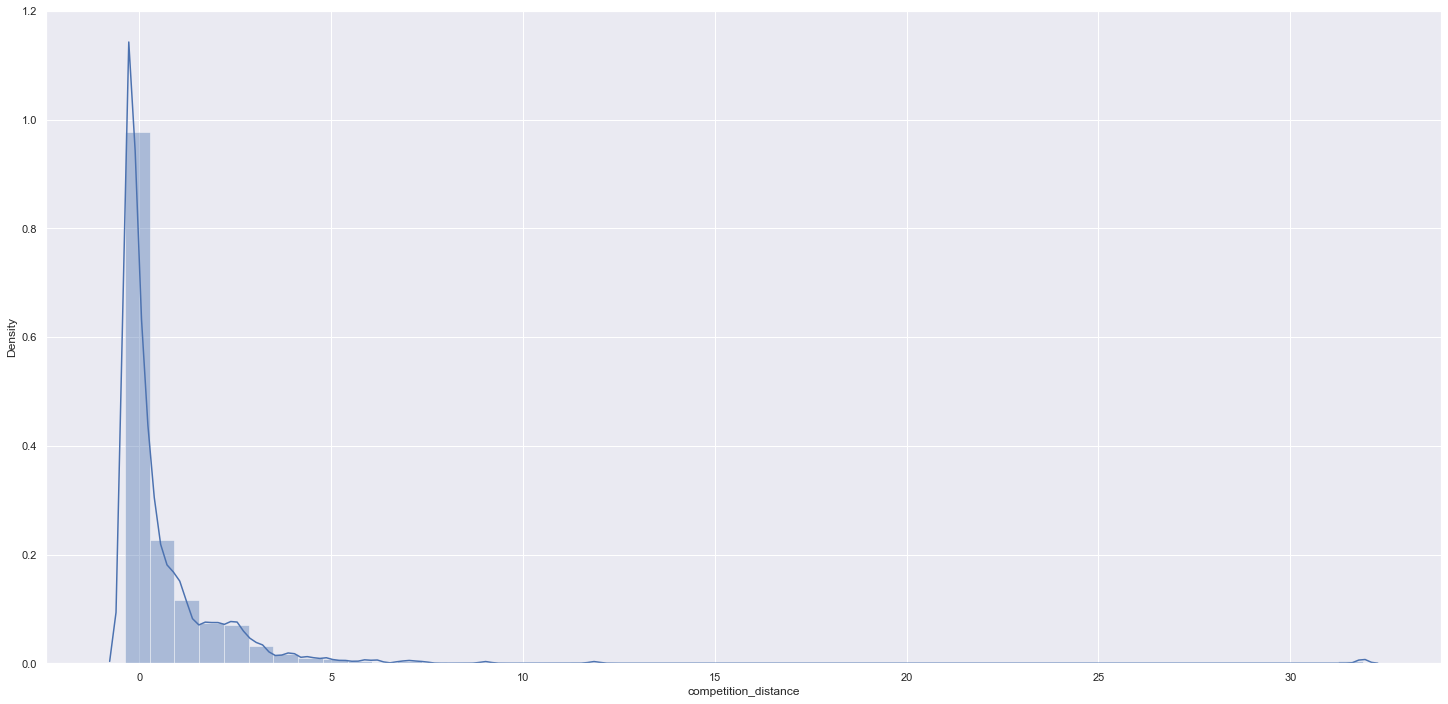

In [74]:
sns.distplot(df5['competition_distance']);

## 5.3 Transformation

### 5.3.1 Encoding

In [75]:
#state_holiday - One Hot Encoding
    # State is a condition, because is a holliday and have a change of behaviour.
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns = ['state_holiday'])

#store_type - Label Encoding
    # Don't has an order. We don't know if A ir bigger than B or C. This can change if we are inside the company and know the meaning of each simbol. 
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

#assortment
    # Exist an order. Basic > extra > extended. We gonna use an Ordinal Encoder.
assortment_dict = {'basic':1, 
                  'extra':2,
                  'extended':3}

df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Transformation of Magnitude

Use the variable response to transform into an normal distribution.

In [76]:
#Buscando uma normalização do valor resposta.
df5['sales'] = np.log1p( df5['sales'])

### 5.3.3 Nature Transformation

The differences between the number from 1 to 12 is very big, one of the ways to transform this is using the trigonometric circle. We gonna extract the sen and cos for each variable. 

In [77]:
# Nature Cicle: 

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2.* np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2.* np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2.* np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2.* np.pi/30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2.* np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2.* np.pi/7 ) ) )

# 6.0 Feature Selection

In [78]:
#Creating a copy of the last one section.

df6 = df5.copy()

## 6.1 Split into test and Train

We will to implement Borutas algorythm to select the main columns for the machine learning code.

In [79]:
cols_drop = ['week_of_year','day_of_week','day','month','promo_since',
            'competition_since','year_week']
df6 = df6.drop(cols_drop, axis=1)

How we are working with a temporal problem, we can't random select the columns that will go to the train and test, because we can take future data and past data, put then mixed on the train and test, this can generate troubles.

In [176]:
df6[['store','date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [177]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

The first date until 18-06 will be the train dataset, the others will be test dataset.

In [80]:
#Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


print(f"Training Min Data: {X_train['date'].min()}")
print(f"Training Max Data: {X_train['date'].max()}")
print(f"\nTest Min Data: {X_test['date'].min()}")
print(f"Test Max Data: {X_test['date'].max()}")

Training Min Data: 2013-01-01 00:00:00
Training Max Data: 2015-06-18 00:00:00

Test Min Data: 2015-06-19 00:00:00
Test Max Data: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [179]:
#define training ant test dataset
X_train_n = X_train.drop(['date','sales'], axis = 1).values
Y_train_n = y_train.values.ravel()


#define RandomForestRegressor
rf = RandomForestRegressor( n_jobs = -1 )

#define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state = 42 ).fit( X_train_n, Y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0


KeyboardInterrupt: 

## 6.3 Best Features from Boruta

In [ ]:
cols_selected = boruta.support_.tolist()

#best features
X_train_fs = X_train.drop(['date','sales'], axis = 1)
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

#Not selected
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

What we need to do right now is compare what we discovered into EDA with the columns selected by Boruta's algorythm.

In [ ]:
print(cols_selected_boruta)

In [81]:
cols_selected_boruta = [
    'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'month_cos',
     'month_sin',
     'day_sin',
     'day_cos',
     'week_of_year_cos',
     'week_of_year_sin',
     'day_of_week_sin',
     'day_of_week_cos'
]

# columns to add
feat_to_add = ['date','sales']


# Final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Machine Learning Models

In [82]:
#Creating a copy of the last one section.

df7 = df6.copy()

In this first cicle of CRISP we gonna use 5 machine learning models. How our objective is generate value quickly, we will not use any complex model. 
If necessary, in the next cycles this gonna change.

## 7.1 Models

### 7.1.1 Average Model

In [86]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

x_training = X_train[cols_selected_boruta_full]

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# Performance

baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

### 7.1.2 Linear Regression Model

In [ ]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

### 7.1.3 Linear Regression Model - Lasso

In [ ]:
# model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

### 7.1.4 Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor(n_estimators=15, n_jobs = -1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

### 7.1.5 XGBoost Regressor

In [87]:
# model
model_xgb = xgb.XGBRegressor().fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[17:14:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1709.208484,0.259029,2453.022655


## 7.2 Cross Validation

### 7.2.1 Linear Regression Cross Validation

In [ ]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)

### 7.2.2 Linear Regression - Lasso - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf)

### 7.2.3 XGBoost - Cross Validation

In [88]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost', model_xgb)

[17:16:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:17:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:18:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## 7.3 Comparing Models

### 7.3.1 Single Performance

In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, xgb_result])
modelling_result.sort_values('RMSE')

### 7.3.2 Real Performance

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv,xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

Random Forest Model has the best result, although we will use XGBoost because the size is much more smaller then Random Forest.

# 8.0 Hyperparameter Fine Tuning

In [ ]:
#Creating a copy of the last one section.

df8 = df7.copy()

## 8.1 Using Random Search

In [91]:
param = {
    'n_estimators':[1500,1700,2500,3000,3500],
    'eta':[0.01,0.03],
    'max_depth':[3,5,9],
    'subsample':[0.1,0.5,0.7],
    'min_child_weight':[3,8,15] }

MAX_EVAL = 10

In [92]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parametrs randomly
    hp = { k: random.sample(v,1)[0] for k,v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor(n_estimators = hp['n_estimators'],
                                eta = hp['eta'],
                                max_depth = hp['max_depth'],
                                subsample = hp['subsample'],
                                min_child_weight = hp['min_child_weight'] )


    # performance
    result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False )
    final_result = pd.concat( [final_result, result] )
    
final_result

TypeError: random_sample() takes at most 1 positional argument (2 given)

In [93]:
param_tuned = {
    'n_estimators':3000,
    'eta':0.03,
    'max_depth':5,
    'subsample':0.7,
    'colsample_bytree': 0.7,
    'min_child_weight':3}

In [94]:
# model
model_xgb_tuned = xgb.XGBRegressor( n_estimators = param_tuned['n_estimators'],
                                    eta = param_tuned['eta'],
                                    max_depth = param_tuned['max_depth'],
                                    subsample = param_tuned['subsample'],
                                    colsample_bytree= param_tuned['colsample_bytree'],
                                    min_child_weight = param_tuned['min_child_weight'] ).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )

xgb_result_tuned

[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,659.61147,0.097461,950.226624


In [95]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.004552018427245783

# 9.0 Interpreting the errors

In [96]:
#Creating a copy of the last one section.

df9 = X_test[ cols_selected_boruta_full ].copy()

In [97]:
#Rescale = Calculate the erros in the same scale of original data.

df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [98]:
# Sum of Predicitions

# How the CEO wants the amount of sales by store, we will doing everything by each store.
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()


# MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x:mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x:mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#Scenarios 
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#Order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [99]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,162523.703125,162217.186919,162830.219331,306.516206,0.069118
1,2,179255.218750,178850.236209,179660.201291,404.982541,0.080292
2,3,268814.937500,268199.034325,269430.840675,615.903175,0.088094
3,4,345173.875000,344298.805664,346048.944336,875.069336,0.084091
4,5,170857.078125,170496.593496,171217.562754,360.484629,0.079073


<AxesSubplot:xlabel='store', ylabel='MAPE'>

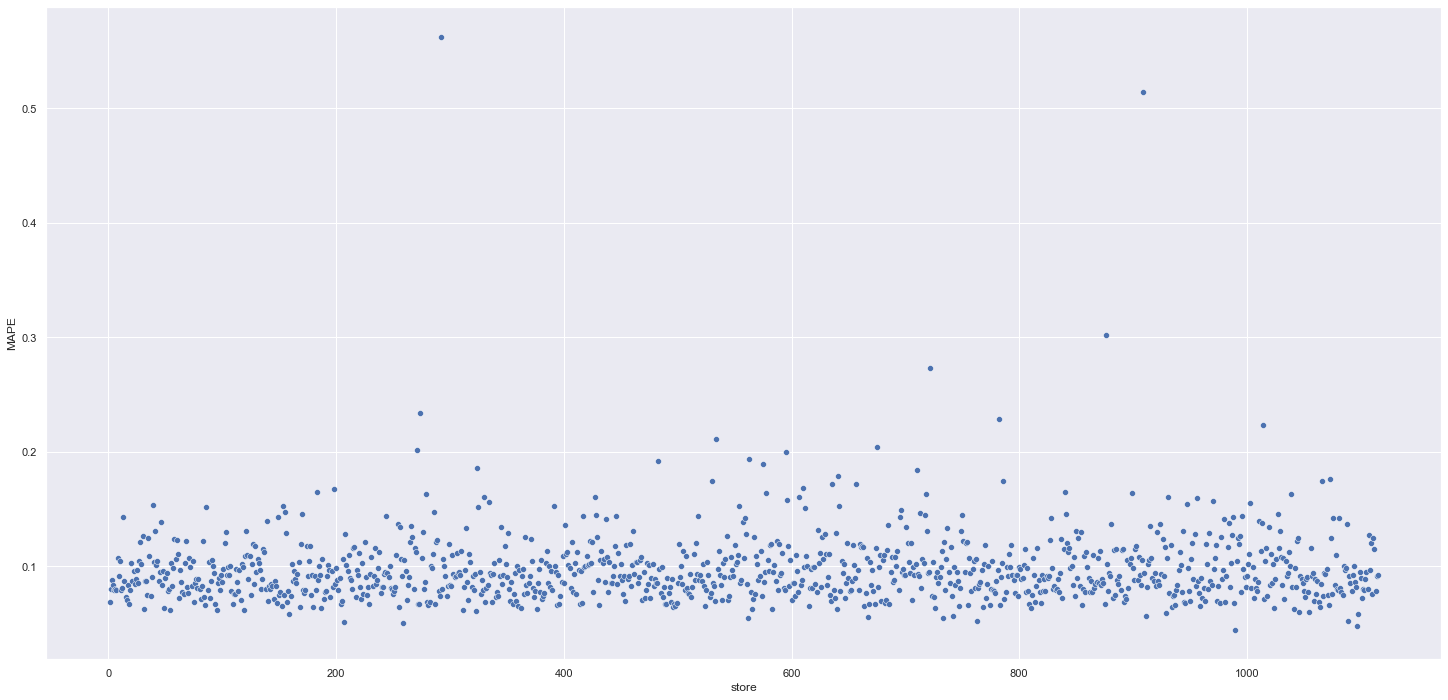

In [103]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2 Total Performance

In [109]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index':'Scenarios', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93.head()

,Scenarios,Values
0,predictions,"R$286,250,144.00"
1,worst_scenario,"R$285,510,590.34"
2,best_scenario,"R$286,989,712.57"


## 9.3 Machine Learning Performance

In [101]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

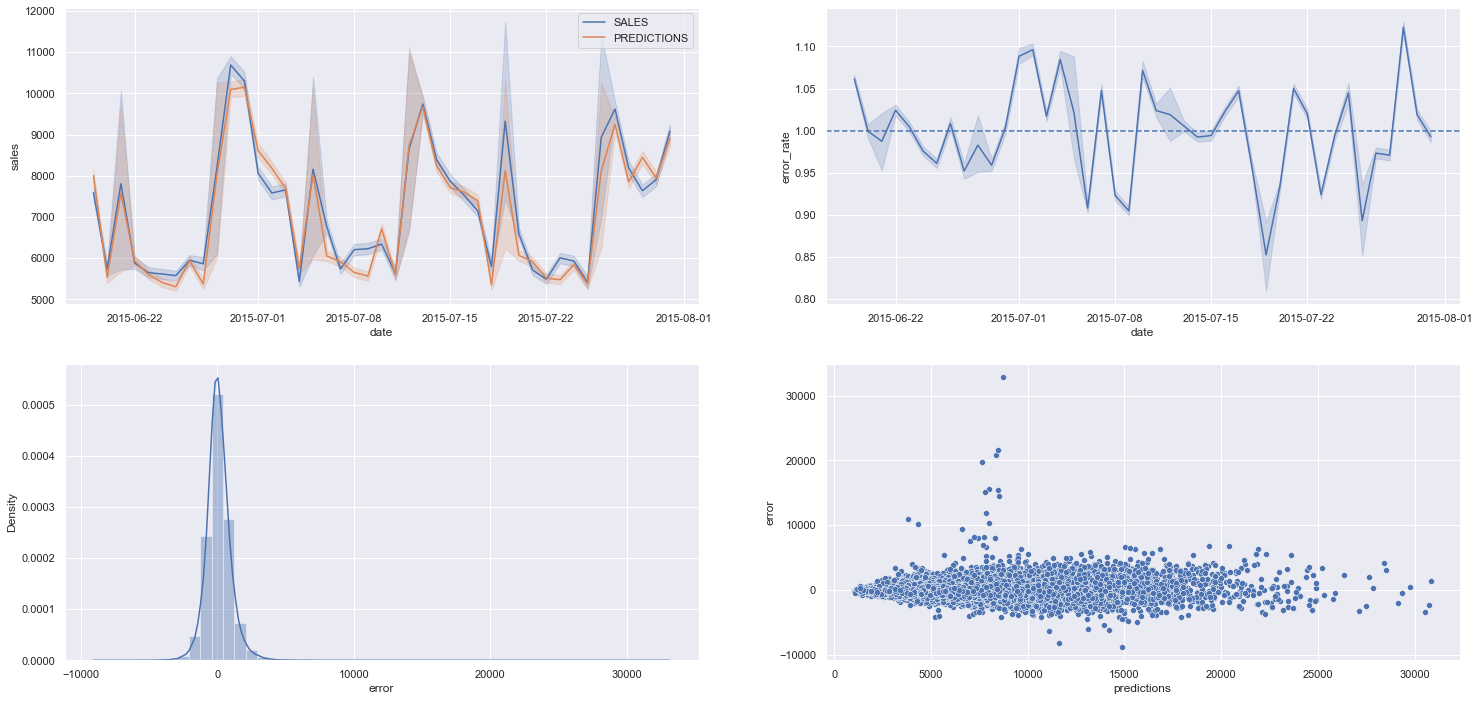

In [102]:
plt.subplot(2,2,1)

sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'SALES');
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'PREDICTIONS');


plt.subplot(2,2,2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9);
plt.axhline(1,linestyle = '--')

plt.subplot(2,2,3)
sns.distplot(df9['error']);

plt.subplot(2,2,4)
sns.scatterplot( df9['predictions'], df9['error']);